
# Investigation of ODI Cricket Data Through Machine Learning

With the 2019 ICC Cricket World Cup now in full swing, I wanted to dig a little deeper into the statistics behind this weird and wonderful game.

There is a vast amount of data collected within cricket. Every ball bowled represents a potentially interesting data point (runs scored, wickets taken), and each has the potential to follow patterns. This project will attempt to identify these patterns through various machine learning techniques, and see what it really takes to win a cricket match.

In the One Day Internation (ODI) format, the team batting first will have 50 overs (6 balls in an over) to amas as higher score as possible whilst the other team attempt to take wickets and limit their score. The second team will then have 50 overs to try and chase down that score. Either team can lose a maximum of 10 wickets within the 50 over innings.

## Data



The dataset we are focussing on is available to download from [this](https://www.kaggle.com/venky73/icc-cricket-world-cup-2019-analysis) Kaggle kernel. The data has been scraped from [https://www.espncricinfo.com/](https://www.espncricinfo.com/) and split into 6 dataframes contained within .csv files. File overview:
1. **ODI_Match_Results.csv** - Contains data regarding the teams involved, who won the toss and whether they chose to bat first or second, what the outcome of the match was, where and when it was played.
1. **ODI_Match_Totals.csv** - Contains data regarding the scores achieved by each team, winning margin, match result, and some data regarding the teams involved, when and where the match played is repeated here.
1. **WC_players.csv** - Contains player information.
1. **Ground_Averages.csv** - Contains aggregated data from various cricket grounds around the world.
1. **Bowler_data.csv** - Contains bowling figures such as balls bowled, wickets taken and bowling economoy.
1. **Batsman_Data.csv** - Contains batting data such as balls faced, runs scored, strike rate, number of boundaries scored.

Initial analysis will focus on the first two dataframes to build up an insight on the following questions:
1. Which team has the highest win percentage?
1. Which teams are most successful in England?
1. Given that a team wins the toss, what is the probability that they win the game?
1. What team is most successful if a toss is won, and which is most successful if a toss is lost?
1. What is the most common choice for each of the English grounds?
1. What is the probability that a team wins their next game, given that the result of their previous game?

Linear Regression models:
* Win predictor
    * Using game stats
    * Using batsmen/ bowler stats
    * Using all stats
    * Using WC matches as a test set.
* Score predictor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

df_match = pd.read_csv('../Data/raw/ODI_Match_Results.csv')
df_totals = pd.read_csv('../Data/raw/ODI_Match_Totals.csv')
df_players = pd.read_csv('../Data/raw/WC_players.csv')
df_ground = pd.read_csv('../Data/raw/Ground_Averages.csv')
df_bowl = pd.read_csv('../Data/raw/Bowler_data.csv')
df_bat = pd.read_csv('../Data/raw/Batsman_Data.csv')

## Assess Data Cleanliness & Tidiness
***
In this section we will assess and document the cleanliness and tidiness of each dataframe, starting with the two key dataframes of interest for match win prediction: `df_match` and `df_totals`.

In [2]:
df_match.shape, df_totals.shape

((1322, 12), (1296, 13))

The dataframes are not equal in size along the zero axis. df_totals potentially missing some data.

In [3]:
df_match

,Unnamed: 0,Result,Margin,BR,Toss,Bat,Opposition,Ground,Start Date,Match_ID,Country,Country_ID
0,418,won,85 runs,NaN,lost,1st,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
1,692,lost,85 runs,NaN,won,2nd,v Pakistan,Kolkata,3 Jan 2013,ODI # 3315,India,6
2,419,lost,10 runs,NaN,lost,2nd,v India,Delhi,6 Jan 2013,ODI # 3316,Pakistan,7
3,693,won,10 runs,NaN,won,1st,v Pakistan,Delhi,6 Jan 2013,ODI # 3316,India,6
4,121,lost,107 runs,NaN,lost,2nd,v Australia,Melbourne,11 Jan 2013,ODI # 3317,SriLanka,8
5,1096,won,107 runs,NaN,won,1st,v Sri Lanka,Melbourne,11 Jan 2013,ODI # 3317,Australia,2
6,694,lost,9 runs,NaN,lost,2nd,v England,Rajkot,11 Jan 2013,ODI # 3318,India,6
7,852,won,9 runs,NaN,won,1st,v India,Rajkot,11 Jan 2013,ODI # 3318,England,1
8,122,won,8 wickets,59.0,won,2nd,v Australia,Adelaide,13 Jan 2013,ODI # 3319,SriLanka,8
9,1097,lost,8 wickets,59.0,lost,1st,v Sri Lanka,Adelaide,13 Jan 2013,ODI # 3319,Australia,2


In [4]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 12 columns):
Unnamed: 0    1322 non-null int64
Result        1322 non-null object
Margin        1322 non-null object
BR            606 non-null float64
Toss          1322 non-null object
Bat           1322 non-null object
Opposition    1322 non-null object
Ground        1322 non-null object
Start Date    1322 non-null object
Match_ID      1322 non-null object
Country       1322 non-null object
Country_ID    1322 non-null int64
dtypes: float64(1), int64(2), object(9)
memory usage: 124.0+ KB


In [5]:
df_match.Match_ID.value_counts()

ODI # 4016     2
ODI # 3755     2
ODI # 3887     2
ODI # 3424     2
ODI # 3514     2
ODI # 3537     2
ODI # 3858     2
ODI # 3815     2
ODI # 3677     2
ODI # 3790     2
ODI # 3828     2
ODI # 3532     2
ODI # 3494     2
ODI # 3517     2
ODI # 3966     2
ODI # 3578     2
ODI # 3579     2
ODI # 3882     2
ODI # 3565     2
ODI # 3656     2
ODI # 3727     2
ODI # 3799     2
ODI # 4119     2
ODI # 3548     2
ODI # 3316     2
ODI # 3916     2
ODI # 3735     2
ODI # 4095     2
ODI # 3570     2
ODI # 3757     2
              ..
ODI # 3972     1
ODI # 4060     1
ODI # 3835     1
ODI # 4129a    1
ODI # 3490     1
ODI # 3983     1
ODI # 3870     1
ODI # 3720     1
ODI # 4136     1
ODI # 3674     1
ODI # 3703     1
ODI # 3508     1
ODI # 3842     1
ODI # 4100     1
ODI # 4006     1
ODI # 3513     1
ODI # 3909a    1
ODI # 3639     1
ODI # 3662     1
ODI # 3988     1
ODI # 4101     1
ODI # 3809     1
ODI # 3337     1
ODI # 3622     1
ODI # 3618     1
ODI # 4138a    1
ODI # 3763     1
ODI # 3744    

In [6]:
df_match.shape[0] - df_match.Match_ID.duplicated(keep=False).sum(), df_match.Match_ID.duplicated().sum()

(196, 563)

In [7]:
df_match.Result.value_counts()

won     663
lost    562
n/r      54
aban     22
tied     14
canc      4
-         3
Name: Result, dtype: int64

Unnamed: 0      0
Result          3
Margin         97
BR            716
Toss           26
Bat            30
Opposition      0
Ground          0
Start Date      0
Match_ID        0
Country         0
Country_ID      0
dtype: int64


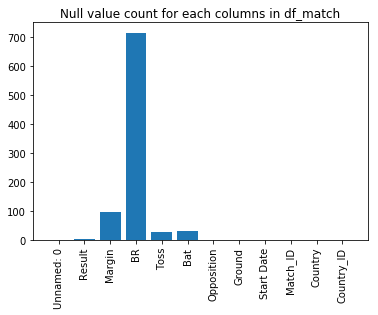

In [8]:
nulls = (df_match == "-").sum() + (df_match.isnull().sum())
print(nulls)

plt.bar(x=nulls.index, height=nulls.values)
plt.xticks(rotation=90);
plt.title("Null value count for each columns in df_match");

### `df_match` cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `BR` non-descriptive name for "Balls Remaining"
- `BR` has 606 null value entries
- "-" is used in place of NaN in `Margin`, `Toss`, `Bat` and `Result` columns
- `Start Date` not in datetime format.
- `Result`, `Toss`, `Bat` columns should be categorical type instead of object.
- `Match_ID` has common prefix "ODI #".
- some `Match_ID` values have suffix "a".
- `Margin` has "runs" and "wickets" suffixes to describe the winning method. Need to separate these to convert to integer.
- `Opposition` column has common prefix "v _Country_"
- `Result` has multiple entries likely to mean match abandoned. \['n/r', 'aban', 'canc'\].
- 563 matches are represented by 2 rows of data, 196 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.

## Assess Data Cleanliness & Tidiness

Now that we have cleaned df_match and exported as a clean.csv file we'll assess the cleanliness of the df_totals and implement the cleaning scripts used previously.

In [9]:
df_totals

,Unnamed: 0,Score,Overs,RPO,Target,Inns,Result,Opposition,Ground,Start Date,Match_ID,Country,Country_ID
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
1,680,165,48.0,3.43,251.0,2,lost,v Pakistan,Kolkata,3 Jan 2013,ODI # 3315,India,6
2,413,157,48.5,3.21,168.0,2,lost,v India,Delhi,6 Jan 2013,ODI # 3316,Pakistan,7
3,681,167,43.4,3.82,NaN,1,won,v Pakistan,Delhi,6 Jan 2013,ODI # 3316,India,6
4,117,198,40.0,4.95,306.0,2,lost,v Australia,Melbourne,11 Jan 2013,ODI # 3317,SriLanka,8
5,1076,305/5,50.0,6.10,NaN,1,won,v Sri Lanka,Melbourne,11 Jan 2013,ODI # 3317,Australia,2
6,682,316/9,50.0,6.32,326.0,2,lost,v England,Rajkot,11 Jan 2013,ODI # 3318,India,6
7,836,325/4,50.0,6.50,NaN,1,won,v India,Rajkot,11 Jan 2013,ODI # 3318,England,1
8,118,172/2,40.1,4.28,171.0,2,won,v Australia,Adelaide,13 Jan 2013,ODI # 3319,SriLanka,8
9,1077,170,46.5,3.62,NaN,1,lost,v Sri Lanka,Adelaide,13 Jan 2013,ODI # 3319,Australia,2


In [10]:
df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 13 columns):
Unnamed: 0    1296 non-null int64
Score         1296 non-null object
Overs         1296 non-null float64
RPO           1296 non-null object
Target        620 non-null float64
Inns          1296 non-null int64
Result        1296 non-null object
Opposition    1296 non-null object
Ground        1296 non-null object
Start Date    1296 non-null object
Match_ID      1296 non-null object
Country       1296 non-null object
Country_ID    1296 non-null int64
dtypes: float64(2), int64(3), object(8)
memory usage: 131.7+ KB


In [11]:
df_totals.Inns.value_counts()

1    656
2    620
0     20
Name: Inns, dtype: int64

In [12]:
df_totals.Match_ID.duplicated().sum(), df_totals.shape[0] - df_totals.Match_ID.duplicated(keep=False).sum()

(554, 188)

Unnamed: 0      0
Score           0
Overs           0
RPO            20
Target        676
Inns            0
Result          3
Opposition      0
Ground          0
Start Date      0
Match_ID        0
Country         0
Country_ID      0
dtype: int64


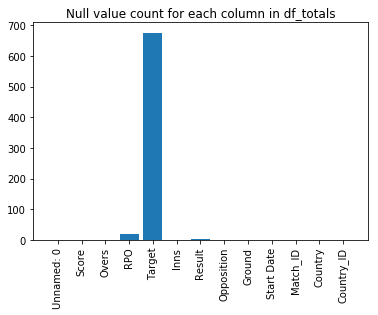

In [13]:
nulls = (df_totals == "-").sum() + df_totals.isnull().sum()
print(nulls)
plt.bar(x=nulls.index, height=nulls.values);
plt.xticks(rotation=90);
plt.title("Null value count for each column in df_totals");

### `df_totals` Cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
- `Result` and `RPO` have "-" in place of NaN values
- `Target` has 676 NaN values because the team batting first does not have a target score.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
- `RPO` is type object, should by type float.
- `Start Date` not in datetime format.
- `Result`, `Inns` columns should be categorical type.
- `Match_ID` has common prefix "ODI #".
- `Opposition` column has common prefix "v _Country_"
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Tidiness
- Columns duplicated between `df_match` and `df_totals`: `Start Date`, `Ground`, `Match_ID`, `Country`, `Country_ID`, `Opposition`, `Result`.
- Some data across both tables can be inferred from other columns and therefore are not independant variables. Related columns: `Score`, `Overs`, `RPO`, `BR`, `Target`, `Margin`
- Data can be restructured into 2 tables with only the `Match_ID` column common between them. 


## Assessment Summary
***
### `df_match` cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `BR` non-descriptive name for "Balls Remaining"
- `BR` has 606 null value entries.
- "-" is used in place of NaN in `Margin`, `Toss`, `Bat` and `Result` columns
- `Start Date` not in datetime format.
- `Result`, `Toss`, `Bat` columns should be categorical type instead of object.
- `Match_ID` has common prefix "ODI #".
- some `Match_ID` values have suffix "a".
- `Margin` has "runs" and "wickets" suffixes to describe the winning method. Need to separate these to convert to integer.
- `Opposition` column has common prefix "v _Country_"
- `Result` has multiple entries likely to mean match abandoned. \['n/r', 'aban', 'canc'\].
- Multiple spellings for Sri Lanka, New Zealand, e.g "SriLanka" & "Sri Lanka". Not all double barrelled country names are sepearated with a space.
- 563 matches are represented by 2 rows of data, 196 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.

`BR` has a large amount of NaN values, but this missing data can be calculated from `df_totals['Overs']` column.
*** 
### `df_totals` Cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
- `Result` and `RPO` have "-" in place of NaN values
- `Target` has 676 NaN values because the team batting first does not have a target score.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
- `RPO` is type object, should by type float.
- `Start Date` not in datetime format.
- `Result`, `Inns` columns should be categorical type.
- `Match_ID` has common prefix "ODI #".
- `Opposition` column has common prefix "v _Country_"
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Tidiness
- Columns duplicated between `df_match` and `df_totals`: `Start Date`, `Ground`, `Match_ID`, `Country`, `Country_ID`, `Opposition`, `Result`.
- Some data across both tables can be inferred from other columns and therefore are not independant variables. Related columns: `Score`, `Overs`, `RPO`, `BR`, `Target`, `Margin`
- Data can be restructured into 2 tables with only the `Match_ID` column common between them. 
***
### Next Steps
 1. Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_totals_clean`.
     - `df_match_clean`:
         - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
         - Each match represented by a single row
         - `result` column will contain the winning team for all completed games that were not tied.
     - `df_totals_clean`:
         - columns: `match_id`, `team`, `opposition`, `toss`, `innings`, `score`, `overs`, `rpo`, `result`, `win_margin`, `win_method`
         - Each match will be represented by two rows of data, one for each team.
         - `result` column will contain "win, lose, draw, n/r" categorical data.
         <br>
         <br>
 2. Implement and test cleaning code on the `df_match_clean` and `df_totals_clean` to address cleanliness issues.
     



## Cleaning & Testing: `df_match`
***
In this section we will implement and test code to address all of the isssues in the assessment summary above. The functions implemented in this section are contained within the clean_data module. Firstly, we will create a path to import this module, then make a copy of `df_match` to maintain the integrity of the data. <br>

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join("../src"))

if module_path not in sys.path:
    sys.path.append(module_path)
    
assert '/home/ding/coding/machine_learning/ODI_cricket/src' in sys.path

from data import clean_data as clean

df_match_clean = df_match.copy()

### Assessment
 - Column names include capital letters and whitsepace characters.
 - `Opposition` column has common prefix "v _Country_"
 - Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_totals_clean`.
 - `df_match_clean`:
     - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
     - Each match represented by a single row
     - `result` column will contain the winning team for all completed games that were not tied.
*** ***
### Define
 - Make all column names lower case with whitsepace characters replaced with "_".
 - Update `result` column to contain the winning team name using `np.where()`
     - It will be more efficient remove the "v _Country_" prefix from the `opposition` column before this step. We'll do this with string slicing.
 - Drop rows with duplicated match id's.
 - Drop columns: `unnamed:_0`, `margin`,`br`, `toss`, `bat`, `country_id` using `pd.drop()`
 - Rename `country` and `oppostion` to `team1` and `team2`.
 - Reorder columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
 

In [25]:
clean.formatHeaders(df_match_clean)

assert all([i.islower() and len(i.split(' ')) == 1 for i in df_match_clean.columns])

df_match_clean.head()

,unnamed:_0,result,margin,br,toss,bat,opposition,ground,start_date,match_id,country,country_id
0,418,won,85 runs,NaN,lost,1st,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
1,692,lost,85 runs,NaN,won,2nd,v Pakistan,Kolkata,3 Jan 2013,ODI # 3315,India,6
2,419,lost,10 runs,NaN,lost,2nd,v India,Delhi,6 Jan 2013,ODI # 3316,Pakistan,7
3,693,won,10 runs,NaN,won,1st,v Pakistan,Delhi,6 Jan 2013,ODI # 3316,India,6
4,121,lost,107 runs,NaN,lost,2nd,v Australia,Melbourne,11 Jan 2013,ODI # 3317,SriLanka,8


In [27]:
df_match_clean['opposition'] = np.where(df_match_clean['opposition'].str.startswith('v'),
                                        df_match_clean['opposition'].str[2:], df_match_clean['opposition'])

df_match_clean.opposition = df_match_clean.opposition.apply(clean.splitUpper)
df_match_clean.opposition = np.where(df_match_clean.opposition == "Newzealad", "New Zealand", df_match_clean.opposition)

df_match_clean.country = df_match_clean.country.apply(clean.splitUpper)
df_match_clean.country = np.where(df_match_clean.country == "Newzealad", "New Zealand", df_match_clean.country)

print(df_match_clean.opposition.value_counts())
print(df_match_clean.country.value_counts())

Sri Lanka       146
India           145
England         139
Australia       129
New Zealand     126
South Africa    122
Pakistan        118
West Indies     103
Zimbabwe         99
Bangladesh       76
Ireland          56
Afghanistan      22
Scotland         22
U. A. E.         11
Hong Kong         4
Kenya             2
P. N. G.          1
Netherlands       1
Name: opposition, dtype: int64
Sri Lanka       162
India           160
England         147
Pakistan        142
South Africa    135
Australia       135
New Zealand     132
West Indies     120
Bangladesh       97
Afghanistan      92
Name: country, dtype: int64


We will be performing a merge with df_totals later and this is a good stage to create a copy of the dataframe for that merge.

In [28]:
df_match_copy = df_match_clean.copy()

### Assessment
 - `df_match_clean`:
     - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
     - Each match represented by a single row
     - `result` column will contain the winning team for all completed games that were not tied.
*** ***
### Define
 - Update `result` column to contain the winning team name using `np.where()`
 - Drop rows with duplicated match id's.
 - Drop columns: `unnamed:_0`, `margin`,`br`, `toss`, `bat`, `country_id` using `pd.drop()`
 - Rename `country` and `oppostion` to `team1` and `team2`.
 - Reorder columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
 

In [29]:
df_match_clean['result'] = np.where(df_match_clean.result == "won", df_match_clean.country,
                                   np.where(df_match_clean.result == "lost", df_match_clean.opposition, df_match_clean.result))
df_match_clean.result.value_counts()

India           183
England         154
South Africa    151
New Zealand     141
Australia       141
Sri Lanka       117
Pakistan        104
Bangladesh       77
West Indies      65
n/r              54
Afghanistan      53
aban             22
Zimbabwe         21
tied             14
Ireland          11
canc              4
-                 3
U. A. E.          3
Scotland          3
Hong Kong         1
Name: result, dtype: int64

In [30]:
old_names = ['country', 'opposition']
new_names = ['team1', 'team2']
        
clean.renameCols(df_match_clean, old_names, new_names)

df_match_clean.head(1)

,unnamed:_0,result,margin,br,toss,bat,team2,ground,start_date,match_id,team1,country_id
0,418,Pakistan,85 runs,NaN,lost,1st,India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7


In [31]:
drop_cols = ['unnamed:_0', 'margin','br', 'toss', 'bat', 'country_id']
df_match_clean.drop(drop_cols, axis=1, inplace=True)
df_match_clean.head(1)

,result,team2,ground,start_date,match_id,team1
0,Pakistan,India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan


In [32]:
drop_index = df_match_clean[df_match_clean.match_id.duplicated()].index
df_match_clean.drop(drop_index, axis=0, inplace=True)

In [33]:
assert not all(df_match_clean.match_id.duplicated())

In [34]:
ordered_cols = ['match_id', 'start_date', 'team1', 'team2', 'ground', 'result']
df_match_clean = df_match_clean[ordered_cols]
df_match_clean.head()

,match_id,start_date,team1,team2,ground,result
0,ODI # 3315,3 Jan 2013,Pakistan,India,Kolkata,Pakistan
2,ODI # 3316,6 Jan 2013,Pakistan,India,Delhi,India
4,ODI # 3317,11 Jan 2013,Sri Lanka,Australia,Melbourne,Australia
6,ODI # 3318,11 Jan 2013,India,England,Rajkot,England
8,ODI # 3319,13 Jan 2013,Sri Lanka,Australia,Adelaide,Sri Lanka


### Assessment
- `Match_ID` has common prefix "ODI #".
- some `Match_ID` values have suffix "a".
***
### Define
- Extract digits from the string using `.str.extract(regex)`.
***
### Code

In [35]:
clean.matchPrefix(df_match_clean, 'match_id')

assert all([len(i) == 4 and type(i) == str for i in df_match_clean.match_id.values])

df_match_clean.head()

,match_id,start_date,team1,team2,ground,result
0,3315,3 Jan 2013,Pakistan,India,Kolkata,Pakistan
2,3316,6 Jan 2013,Pakistan,India,Delhi,India
4,3317,11 Jan 2013,Sri Lanka,Australia,Melbourne,Australia
6,3318,11 Jan 2013,India,England,Rajkot,England
8,3319,13 Jan 2013,Sri Lanka,Australia,Adelaide,Sri Lanka


### Assessment
- `Result` has multiple entries likely to mean match abandoned. \['n/r', 'aban', 'canc'\].
***
### Define
- Set all values in the list to 'n/r' using `np.where()`
***
### Code

In [36]:
no_results = ['n/r', 'aban', 'canc']

clean.commonValue(df_match_clean, 'result', no_results, 'n/r')

for val in no_results[1:]:
    assert all(df_match_clean.result != val)
    
df_match_clean.result.value_counts()

India           99
South Africa    82
England         80
New Zealand     73
Australia       73
Sri Lanka       63
Pakistan        61
Bangladesh      47
n/r             47
Afghanistan     46
West Indies     39
Zimbabwe        21
Ireland         11
tied             8
Scotland         3
U. A. E.         3
-                2
Hong Kong        1
Name: result, dtype: int64

### Assessment
- "-" is used in place of NaN in `Margin`, `Toss`, `Bat` and `Result` columns
***
### Define
- Set all "-" values in `result` to np.NaN using `np.where()`
***
### Code

In [37]:
clean.countVal(df_match_clean, '-')

[{'match_id': 0},
 {'start_date': 0},
 {'team1': 0},
 {'team2': 0},
 {'ground': 0},
 {'result': 2}]

In [38]:
clean.replaceNaN(df_match_clean, "-")
clean.countVal(df_match_clean, '-')

[{'match_id': 0},
 {'start_date': 0},
 {'team1': 0},
 {'team2': 0},
 {'ground': 0},
 {'result': 0.0}]

### Assessment
- `Start Date` not in datetime format.
***
### Define
- Change datatype from object to datetime using `pd.to_datetime()`
***
### Code

In [39]:
df_match_clean.start_date = pd.to_datetime(df_match_clean.start_date)

In [40]:
df_match_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759 entries, 0 to 1320
Data columns (total 6 columns):
match_id      759 non-null object
start_date    759 non-null datetime64[ns]
team1         759 non-null object
team2         759 non-null object
ground        759 non-null object
result        757 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 41.5+ KB


We have now addressed all of the issues highlighted in the assessment summary for `df_match` so we can write this as a new .csv file.

In [41]:
df_match_clean.to_csv('../Data/interim/ODI_match_clean.csv', index=False)

In [42]:
df_match_clean.head()

,match_id,start_date,team1,team2,ground,result
0,3315,2013-01-03,Pakistan,India,Kolkata,Pakistan
2,3316,2013-01-06,Pakistan,India,Delhi,India
4,3317,2013-01-11,Sri Lanka,Australia,Melbourne,Australia
6,3318,2013-01-11,India,England,Rajkot,England
8,3319,2013-01-13,Sri Lanka,Australia,Adelaide,Sri Lanka


## Cleaning & Testing: `df_totals`
***
In this section we will implement and test code to address all of the isssues in the assessment sumary above.  Firstly, we will make copies of `df_match` and `df_totals` to maintain the integrity of the data.

### `df_totals` Cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
- `Result` and `RPO` have "-" in place of NaN values
- `Target` has 676 NaN values because the team batting first does not have a target score.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
- `RPO` is type object, should by type float.
- `Start Date` not in datetime format.
- `Result`, `Inns` columns should be categorical type.
- `Match_ID` has common prefix "ODI #".
- `Opposition` column has common prefix "v _Country_"
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Tidiness
- Columns duplicated between `df_match` and `df_totals`: `Start Date`, `Ground`, `Match_ID`, `Country`, `Country_ID`, `Opposition`, `Result`.
- Some data across both tables can be inferred from other columns and therefore are not independant variables. Related columns: `Score`, `Overs`, `RPO`, `BR`, `Target`, `Margin`
- Data can be restructured into 2 tables with only the `Match_ID` column common between them. 
***
### Next Steps
 1. Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_totals_clean`.
     - `df_match_clean`:
         - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
         - Each match represented by a single row
         - `result` column will contain the winning team for all completed games that were not tied.
     - `df_totals_clean`:
         - columns: `match_id`, `team`, `opposition`, `toss`, `innings`, `score`, `overs`, `rpo`, `result`, `win_margin`, `win_method`
         - Each match will be represented by two rows of data, one for each team.
         - `result` column will contain "win, lose, draw, n/r" categorical data.
         <br>
         <br>
 2. Implement and test cleaning code on the `df_match_clean` and `df_totals_clean` to address cleanliness issues.

### Assessment
- Column names include capital letters and whitsepace characters.
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Define
- Implement `formatHeaders()` to make columns easier to work with.
- Gather missing data from https://www.espncricinfo.com
     - Requests and BeautifulSoup libraries are imported in clean_data
     
***
### Code


In [3]:
# Import gather_data module
from data import gather_data as gather

# Create df copies for cleaning
df_totals_clean = df_totals.copy()
df_match_copy = df_match.copy()
df_totals_missing = pd.read_csv('../Data/interim/missing_totals_data.csv') ## MUST CHANGE THIS
df_totals_missing_clean = df_totals_missing.copy()

df_totals_clean.head(2)

,Unnamed: 0,Score,Overs,RPO,Target,Inns,Result,Opposition,Ground,Start Date,Match_ID,Country,Country_ID
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
1,680,165,48.0,3.43,251.0,2,lost,v Pakistan,Kolkata,3 Jan 2013,ODI # 3315,India,6


In [263]:
df_match_copy.head(2)

,Unnamed: 0,Result,Margin,BR,Toss,Bat,Opposition,Ground,Start Date,Match_ID,Country,Country_ID
0,418,won,85 runs,NaN,lost,1st,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
1,692,lost,85 runs,NaN,won,2nd,v Pakistan,Kolkata,3 Jan 2013,ODI # 3315,India,6


In [151]:
df_totals_missing_clean.head(2)

,match_id,team,score,detailed_score
0,ODI no. 3337,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)"
1,ODI no. 3337,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)"


In [4]:
df_list = [df_match_copy, df_totals_clean, df_totals_missing_clean]

for df in df_list:
    clean.formatHeaders(df)
    
assert all([i.islower() and len(i.split(" ")) == 1 for i in df_totals_clean.columns])
assert all([i.islower() and len(i.split(" ")) == 1 for i in df_totals_missing_clean.columns])
assert all([i.islower() and len(i.split(" ")) == 1 for i in df_match_copy.columns])

df_totals_clean.head(1)

,unnamed:_0,score,overs,rpo,target,inns,result,opposition,ground,start_date,match_id,country,country_id
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7


In [328]:
# df_temp.country.str.extract('([A-Z][a-z]+[A-Z]?[a-z]+[A-Z]?[a-z]+)')
df_temp.country.str.extract('([A-Z][^A-Z]*)')

import re

# Get soup from initial url
soup = gather.getSoup("http://stats.espncricinfo.com/ci/content/records/307851.html")

# Get all relative links from soup
all_links = gather.yearPageLinks(soup)

# Filter on links in target years
years = ["2013", "2014", "2015", "2016","2017","2018","2019"]
filt_links = gather.filterLinks(all_links, years)

# Get absolute links from relative links
prefix = "http://stats.espncricinfo.com/"
abs_links = gather.absoluteUrl(prefix, filt_links)

# Get match_ids with only 1 entry
match_ids = df_totals_clean[~df_totals_clean.match_id.duplicated(keep=False)].match_id.values

# Get scorecard links associated to each match_id
rel_sc_links = gather.scorecardLinks(abs_links, match_ids)
prefix = "https://www.espncricinfo.com/"
abs_sc_links = gather.absoluteUrl(prefix, rel_sc_links)

# Check we have links for all match_ids
assert len(match_ids) == len(abs_sc_links)

In [125]:
score_master = {'match_id':[], 'team':[], 'score':[], 'detailed_score':[]}

# Extract missing information from urls
counter=1
for url in abs_sc_links:
   score_dct = gather.getMissingData(url)
   print(counter)
   counter+=1
   for key in score_dct:
      score_master[key].extend(score_dct[key])
            
# Create df from score_master dct
df = pd.DataFrame(data=score_master, columns=['match_id', 'team', 'score', 'detailed_score'])

# Test that we have 2 entries for every match_id
assert df.shape[0] == 2*len(match_ids)

NameError: name 'abs_sc_links' is not defined

In [ ]:
df.to_csv('../Data/interim/missing_totals_data.csv', index=False)

In [5]:
df_totals_missing = pd.read_csv('../Data/interim/missing_totals_data.csv')
df_totals_missing_clean = df_totals_missing.copy()
df_totals_missing_clean.head()

,match_id,team,score,detailed_score
0,ODI no. 3337,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)"
1,ODI no. 3337,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)"
2,ODI no. 3339,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)"
3,ODI no. 3339,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)"
4,ODI no. 3340,Zimbabwe,211/9,"211/9 (50 Overs, RR: 4.22)"


In [8]:
df_totals_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 4 columns):
match_id          376 non-null object
team              376 non-null object
score             366 non-null object
detailed_score    366 non-null object
dtypes: object(4)
memory usage: 11.8+ KB


Now that we have collected the missing data for matches represented by a single row, we can import additional data from the `df_match_copy` dataframe made earlier and prepare the data for appending to `dt_totals_clean`.

### Assessment
- `Match_ID` has common prefix "ODI #".
- `Match_ID` has common prefix "ODI no.".
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
- Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_totals_clean`.
     - `df_match_clean`:
         - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
         - Each match represented by a single row
         - `result` column will contain the winning team for all completed games that were not tied.
     - `df_totals_clean`:
         - columns: `match_id`, `team`, `opposition`, `toss`, `innings`, `score`, `overs`, `rpo`, `result`, `win_margin`, `win_method`
         - Each match will be represented by two rows of data, one for each team.
         - `result` column will contain "win, lose, draw, n/r" categorical data.
***
### Define
- Extract numeric digits from match_id columns `df_match_copy`, in `df_totals_clean` and `df_totals_missing_clean` to make the values column across all tables.
- Merge `toss`, `bat`, `margin` columns from `df_match_copy` into `df_totals_clean` aligned on `match_id` and `country` usind `pd.merge()`. Left join to retain only match ids that are in `df_totals_clean` 
- Append missing data in `df_totals_missing_clean` into `df_totals_clean` on `match_id` and `country` using `pd.merge()`. Join must be outer to include the new missing rows.
***
### Code


In [9]:
df_list = [df_match_copy, df_totals_clean, df_totals_missing_clean]

for df in df_list:
    clean.matchPrefix(df, 'match_id')
    
assert all([len(i) == 4 and type(i) == str for i in df_match_copy.match_id.values])
assert all([len(i) == 4 and type(i) == str for i in df_totals_clean.match_id.values])
assert all([len(i) == 4 and type(i) == str for i in df_totals_missing_clean.match_id.values])

df_totals_clean.match_id.values

array(['3315', '3315', '3316', ..., '4139', '4140', '4140'], dtype=object)

In [10]:
df_totals_missing_clean.team.value_counts()

Zimbabwe                99
Afghanistan             68
Ireland                 51
Pakistan                22
Bangladesh              20
Scotland                19
West Indies             16
India                   15
Sri Lanka               14
South Africa            13
United Arab Emirates    11
England                  8
Australia                6
New Zealand              6
Hong Kong                4
Kenya                    2
Netherlands              1
Papua New Guinea         1
Name: team, dtype: int64

In [11]:
df_match_copy.head()

,unnamed:_0,result,margin,br,toss,bat,opposition,ground,start_date,match_id,country,country_id
0,418,won,85 runs,NaN,lost,1st,v India,Kolkata,3 Jan 2013,3315,Pakistan,7
1,692,lost,85 runs,NaN,won,2nd,v Pakistan,Kolkata,3 Jan 2013,3315,India,6
2,419,lost,10 runs,NaN,lost,2nd,v India,Delhi,6 Jan 2013,3316,Pakistan,7
3,693,won,10 runs,NaN,won,1st,v Pakistan,Delhi,6 Jan 2013,3316,India,6
4,121,lost,107 runs,NaN,lost,2nd,v Australia,Melbourne,11 Jan 2013,3317,SriLanka,8


In [12]:
df_merge = df_totals_clean.merge(df_match_copy.loc[:, ['match_id', 'country', 'margin', 'toss', 'bat', 'result']], \
                                        on=['match_id','country'], how='left', suffixes=['','_m'])

assert all(df_merge.result == df_merge.result_m)
# assert df_merge.match_id.duplicated().sum() == df_merge.shape[0]/2

AssertionError: 

The first assertion test above checks that all values in `result` (originally from `df_totals_clean`) match the values in `result_m` (originally from `df_match_copy`) and raises and error. After further investigation, some match ids in the data sets prior to merging appear 4 times due to matches being abandoned and rescheduled for another date. The third test checks that all match_ids are duplicates **exactly** once and also fails. We will drop the rows where `result` and `result_m` do not match and repeat the tests.  <br>




After further investigation, some match ids in the data sets prior to merging appear 4 times due to matches being abandoned and rescheduled for another date. We will clean these entries to ensure that all match ids appear exactly twice in the final dataframe.

In [13]:
df_match_copy[df_match_copy.match_id.isin(df_merge[df_merge.result != df_merge.result_m].match_id.values)]

,unnamed:_0,result,margin,br,toss,bat,opposition,ground,start_date,match_id,country,country_id
70,425,won,96 runs,NaN,won,1st,v Scotland,Edinburgh,17 May 2013,3356,Pakistan,7
71,426,aban,-,NaN,-,-,v Scotland,Edinburgh,19 May 2013,3356,Pakistan,7
154,1109,won,200 runs,NaN,lost,1st,v Scotland,Edinburgh,3 Sep 2013,3410,Australia,2
155,869,aban,-,NaN,-,-,v Australia,Leeds,6 Sep 2013,3410,England,1
156,1110,aban,-,NaN,-,-,v England,Leeds,6 Sep 2013,3410,Australia,2
173,717,n/r,-,NaN,won,2nd,v Australia,Ranchi,23 Oct 2013,3422,India,6
174,1118,n/r,-,NaN,lost,1st,v India,Ranchi,23 Oct 2013,3422,Australia,2
175,718,aban,-,NaN,-,-,v Australia,Cuttack,26 Oct 2013,3422,India,6
176,1119,aban,-,NaN,-,-,v India,Cuttack,26 Oct 2013,3422,Australia,2
298,159,won,79 runs,NaN,lost,1st,v Ireland,Dublin,6 May 2014,3490,SriLanka,8


In [14]:
df_merge[df_merge.result != df_merge.result_m].head(10)

,unnamed:_0,score,overs,rpo,target,inns,result,opposition,ground,start_date,match_id,country,country_id,margin,toss,bat,result_m
71,419,231/7,50.0,4.62,NaN,1,won,v Scotland,Edinburgh,17 May 2013,3356,Pakistan,7,-,-,-,aban
155,1089,362/3,50.0,7.24,NaN,1,won,v Scotland,Edinburgh,3 Sep 2013,3410,Australia,2,-,-,-,aban
173,705,27/0,4.1,6.48,296.0,2,n/r,v Australia,Ranchi,23 Oct 2013,3422,India,6,-,-,-,aban
175,1097,295/8,50.0,5.90,NaN,1,n/r,v India,Ranchi,23 Oct 2013,3422,Australia,2,-,-,-,aban
296,155,219/8,50.0,4.38,NaN,1,won,v Ireland,Dublin,6 May 2014,3490,SriLanka,8,-,-,-,aban
368,37,271,48.1,5.62,331.0,2,lost,v India,Dharamsala,17 Oct 2014,3535,WestIndies,4,-,-,-,canc
370,732,330/6,50.0,6.60,NaN,1,won,v West Indies,Dharamsala,17 Oct 2014,3535,India,6,-,-,-,canc
730,1246,178/6,37.2,4.76,NaN,1,won,v Scotland,Edinburgh,6 Jul 2016,3760,Afghanistan,40,-,-,-,aban
736,491,337/6,47.0,7.17,NaN,1,won,v Ireland,Dublin (Malahide),18 Aug 2016,3767,Pakistan,7,-,-,-,aban


In [15]:
df_merge = df_merge[df_merge.result == df_merge.result_m]
assert all(df_merge.result == df_merge.result_m)

In [16]:
df_merge.drop('result_m', axis=1, inplace=True)
df_merge.head()

,unnamed:_0,score,overs,rpo,target,inns,result,opposition,ground,start_date,match_id,country,country_id,margin,toss,bat
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,3315,Pakistan,7,85 runs,lost,1st
1,680,165,48.0,3.43,251.0,2,lost,v Pakistan,Kolkata,3 Jan 2013,3315,India,6,85 runs,won,2nd
2,413,157,48.5,3.21,168.0,2,lost,v India,Delhi,6 Jan 2013,3316,Pakistan,7,10 runs,lost,2nd
3,681,167,43.4,3.82,NaN,1,won,v Pakistan,Delhi,6 Jan 2013,3316,India,6,10 runs,won,1st
4,117,198,40.0,4.95,306.0,2,lost,v Australia,Melbourne,11 Jan 2013,3317,SriLanka,8,107 runs,lost,2nd


Now that we have successfully merged the target data from `df_match_copy` we can merge this into `df_totals_missing_clean` and prepare for appending.

In [17]:
df_totals_missing_clean.head(4)

,match_id,team,score,detailed_score
0,3337,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)"
1,3337,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)"
2,3339,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)"
3,3339,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)"


In [18]:
df_totals_missing_clean['overs'] = df_totals_missing_clean.detailed_score.str.extract('\((\d+)').astype(float)
df_totals_missing_clean['rpo'] = df_totals_missing_clean.detailed_score.str.extract(': (\d\.\d+)').astype(float)
df_totals_missing_clean.drop('detailed_score', axis=1, inplace=True)

# df_totals_missing_clean.drop('start_date', axis=1, inplace=True)
# df_totals_missing_clean = df_totals_missing_clean.merge(df.loc[:,['match_id','start_date']], on='match_id')

In [19]:
df_totals_missing_clean.head(4)

,match_id,team,score,overs,rpo
0,3337,West Indies,337/4,50.0,6.74
1,3337,Zimbabwe,181/9,50.0,3.62
2,3339,Zimbabwe,273/8,50.0,5.46
3,3339,West Indies,274/3,49.0,5.59


In [20]:
df_temp = df_merge[~df_merge.match_id.duplicated(keep=False)]
df_temp.head()

,unnamed:_0,score,overs,rpo,target,inns,result,opposition,ground,start_date,match_id,country,country_id,margin,toss,bat
44,6,337/4,50.0,6.74,NaN,1,won,v Zimbabwe,St George's,22 Feb 2013,3337,WestIndies,4,156 runs,lost,1st
47,7,274/3,49.0,5.59,274.0,2,won,v Zimbabwe,St George's,24 Feb 2013,3339,WestIndies,4,7 wickets,lost,2nd
48,8,215/5,46.2,4.64,212.0,2,won,v Zimbabwe,St George's,26 Feb 2013,3340,WestIndies,4,5 wickets,lost,2nd
49,1207,203/3,33.5,6.00,200.0,2,won,v Scotland,Sharjah,6 Mar 2013,3341,Afghanistan,40,7 wickets,lost,2nd
50,1208,261/5,48.4,5.36,260.0,2,won,v Scotland,Sharjah,8 Mar 2013,3342,Afghanistan,40,5 wickets,won,2nd


Before merging on match id and team it is important that the country names are equivalet in both dataframes. Currently `df_totals_missing_clean` has a space in double-barrelled country names, whilst `df_totals_clean` has no spaces and some spelling errors with "Newzealad". We'll change the country names in `df_merge` and to remain consistent we'll need to change the country names in `df_match` also.

In [21]:
# import importlib
# importlib.reload(clean)
df_temp.country = np.where(df_temp.country == 'Newzealad', 'NewZealand', df_temp.country)
df_temp.country = df_temp.country.apply(clean.splitUpper)
df_merge.country = df_merge.country.apply(clean.splitUpper)

df_temp.country.value_counts()

/home/ding/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Afghanistan     68
Pakistan        22
Bangladesh      20
West Indies     16
India           15
Sri Lanka       14
South Africa    13
England          8
New Zealand      6
Australia        6
Name: country, dtype: int64

In [22]:
df_temp2 = df_totals_missing_clean.merge(df_temp, left_on=['match_id','team'], right_on=['match_id','country'],
                             how='outer', suffixes=['','_t'])
df_temp2.head()

,match_id,team,score,overs,rpo,unnamed:_0,score_t,overs_t,rpo_t,target,inns,result,opposition,ground,start_date,country,country_id,margin,toss,bat
0,3337,West Indies,337/4,50.0,6.74,6.0,337/4,50.0,6.74,NaN,1.0,won,v Zimbabwe,St George's,22 Feb 2013,West Indies,4.0,156 runs,lost,1st
1,3337,Zimbabwe,181/9,50.0,3.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3339,Zimbabwe,273/8,50.0,5.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3339,West Indies,274/3,49.0,5.59,7.0,274/3,49.0,5.59,274.0,2.0,won,v Zimbabwe,St George's,24 Feb 2013,West Indies,4.0,7 wickets,lost,2nd
4,3340,Zimbabwe,211/9,50.0,4.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def fillMissingData(df, idx_list):
    for i in idx_list:
        if df.loc[i,'match_id'] == df.loc[i+1,'match_id']:
            row = i+1
        elif df.loc[i,'match_id'] == df.loc[i-1,'match_id']:
            row = i-1
        else:
            print("Match ID does not preceed or superceed index")


        df.loc[i,'inns'] = np.where(df.loc[row, 'inns']==1, 2.0, 1.0)
        if df.loc[row, 'result'] == 'won':
            df.loc[i, 'result'] = 'lost'
        elif df.loc[row, 'result'] == 'lost':
            df.loc[i, 'result'] = 'won'
        else:
            df.loc[i, 'result'] = df.loc[row, 'result']

        if df.loc[row, 'bat'] == '1st':
            df.loc[i, 'bat'] = '2nd'
        elif df.loc[row, 'bat'] == '2nd':
            df.loc[i, 'bat'] = '1st'

        if df.loc[row, 'toss'] == 'won':
            df.loc[i, 'toss'] = 'lost'
        elif df.loc[row, 'toss'] == 'lost':
            df.loc[i, 'toss'] = 'won'

        df.loc[i,'opposition'] = df.loc[row, 'team']
        df.loc[i, 'start_date'] = df.loc[row, 'start_date']
        df.loc[i,'margin'] = df.loc[row, 'margin']
            

In [24]:
idx = df_temp2[df_temp2.score_t.isnull()].index
fillMissingData(df_temp2, idx)

assert all(df_temp2.result.notnull())
assert all(df_temp2.bat.notnull())
assert all(df_temp2.toss.notnull())
assert all(df_temp2.opposition.notnull())
assert all(df_temp2.start_date.notnull())
assert all(df_temp2.margin.notnull())

In [25]:
df_temp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 0 to 375
Data columns (total 20 columns):
match_id      376 non-null object
team          376 non-null object
score         366 non-null object
overs         366 non-null float64
rpo           366 non-null float64
unnamed:_0    188 non-null float64
score_t       188 non-null object
overs_t       188 non-null float64
rpo_t         188 non-null object
target        82 non-null float64
inns          376 non-null float64
result        376 non-null object
opposition    376 non-null object
ground        188 non-null object
start_date    376 non-null object
country       188 non-null object
country_id    188 non-null float64
margin        376 non-null object
toss          376 non-null object
bat           376 non-null object
dtypes: float64(7), object(13)
memory usage: 71.7+ KB


In [26]:
drop_cols = ['country','rpo_t','score_t','overs_t']
df_temp2.drop(drop_cols,axis=1,inplace=True)
clean.renameCols(df_temp2, ['team'], ['country'])

# assert df_temp2.columns.values.sort() == df_merge.columns.values.sort()

We're now ready to complete the merge. To do this we'll drop all of the none duplicated match id's from df_merge then append the data in df_temp2.

In [27]:
df_merge.country.value_counts()

Sri Lanka       160
India           156
England         145
Pakistan        139
South Africa    135
Australia       131
Newzealad       129
West Indies     116
Bangladesh       95
Afghanistan      90
Name: country, dtype: int64

In [28]:
df_merge = df_merge[df_merge.match_id.duplicated(keep=False)]
df_merge.head()

,unnamed:_0,score,overs,rpo,target,inns,result,opposition,ground,start_date,match_id,country,country_id,margin,toss,bat
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,3315,Pakistan,7,85 runs,lost,1st
1,680,165,48.0,3.43,251.0,2,lost,v Pakistan,Kolkata,3 Jan 2013,3315,India,6,85 runs,won,2nd
2,413,157,48.5,3.21,168.0,2,lost,v India,Delhi,6 Jan 2013,3316,Pakistan,7,10 runs,lost,2nd
3,681,167,43.4,3.82,NaN,1,won,v Pakistan,Delhi,6 Jan 2013,3316,India,6,10 runs,won,1st
4,117,198,40.0,4.95,306.0,2,lost,v Australia,Melbourne,11 Jan 2013,3317,Sri Lanka,8,107 runs,lost,2nd


In [29]:
df_temp2.head()

,match_id,country,score,overs,rpo,unnamed:_0,target,inns,result,opposition,ground,start_date,country_id,margin,toss,bat
0,3337,West Indies,337/4,50.0,6.74,6.0,NaN,1.0,won,v Zimbabwe,St George's,22 Feb 2013,4.0,156 runs,lost,1st
1,3337,Zimbabwe,181/9,50.0,3.62,NaN,NaN,2.0,lost,West Indies,NaN,22 Feb 2013,NaN,156 runs,won,2nd
2,3339,Zimbabwe,273/8,50.0,5.46,NaN,NaN,1.0,lost,West Indies,NaN,24 Feb 2013,NaN,7 wickets,won,1st
3,3339,West Indies,274/3,49.0,5.59,7.0,274.0,2.0,won,v Zimbabwe,St George's,24 Feb 2013,4.0,7 wickets,lost,2nd
4,3340,Zimbabwe,211/9,50.0,4.22,NaN,NaN,1.0,lost,West Indies,NaN,26 Feb 2013,NaN,5 wickets,won,1st


In [30]:
col_order = ['match_id', 'country', 'score', 'overs', 'rpo', 'unnamed:_0', 'target',
       'inns', 'result', 'opposition', 'ground', 'start_date', 'country_id',
       'margin', 'toss', 'bat']
df_merge = df_merge[col_order]

In [33]:
df_merge = df_merge.append(df_temp2, sort=False)

In [34]:
assert df_merge.match_id.duplicated().sum() == df_merge.shape[0]/2

In [35]:
df_merge.match_id.duplicated().sum(), df_merge.shape[0]/2

(742, 742.0)

In [37]:
df_merge.head()

,match_id,country,score,overs,rpo,unnamed:_0,target,inns,result,opposition,ground,start_date,country_id,margin,toss,bat
0,3315,Pakistan,250,48.3,5.15,412.0,NaN,1.0,won,v India,Kolkata,3 Jan 2013,7.0,85 runs,lost,1st
1,3315,India,165,48.0,3.43,680.0,251.0,2.0,lost,v Pakistan,Kolkata,3 Jan 2013,6.0,85 runs,won,2nd
2,3316,Pakistan,157,48.5,3.21,413.0,168.0,2.0,lost,v India,Delhi,6 Jan 2013,7.0,10 runs,lost,2nd
3,3316,India,167,43.4,3.82,681.0,NaN,1.0,won,v Pakistan,Delhi,6 Jan 2013,6.0,10 runs,won,1st
4,3317,Sri Lanka,198,40.0,4.95,117.0,306.0,2.0,lost,v Australia,Melbourne,11 Jan 2013,8.0,107 runs,lost,2nd


In [38]:
df_merge.shape

(1484, 16)

All match ids are represented by 2 rows and we have filled in all of the missing data that we need. We can now address the remaining cleaning tasks we highlighted earlier.

### Assessment
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
- `Result` and `RPO` have "-" in place of NaN values
- `Target` has 676 NaN values because the team batting first does not have a target score.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
- `RPO` is type object, should by type float.
- `Start Date` not in datetime format.
- `Result`, `Inns` columns should be categorical type.
- `Opposition` column has common prefix "v _Country_"

***
### Next Steps
 1. Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_totals_clean`.
     - `df_totals_clean`:
         - columns: `match_id`, `team`, `opposition`, `toss`, `innings`, `score`, `overs`, `rpo`, `result`, `win_margin`, `win_method`
         - Each match will be represented by two rows of data, one for each team.
         - `result` column will contain "win, lose, draw, n/r" categorical data.

In [39]:
df_totals_clean = df_merge.copy()
df_totals_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484 entries, 0 to 375
Data columns (total 16 columns):
match_id      1484 non-null object
country       1484 non-null object
score         1474 non-null object
overs         1474 non-null float64
rpo           1474 non-null object
unnamed:_0    1296 non-null float64
target        620 non-null float64
inns          1484 non-null float64
result        1484 non-null object
opposition    1484 non-null object
ground        1296 non-null object
start_date    1484 non-null object
country_id    1296 non-null float64
margin        1484 non-null object
toss          1484 non-null object
bat           1484 non-null object
dtypes: float64(5), object(11)
memory usage: 197.1+ KB


In [40]:
drop_cols = ['unnamed:_0', 'target','ground', 'country_id']
df_totals_clean.drop(drop_cols, axis=1,inplace=True)
df_totals_clean.head()

,match_id,country,score,overs,rpo,inns,result,opposition,start_date,margin,toss,bat
0,3315,Pakistan,250,48.3,5.15,1.0,won,v India,3 Jan 2013,85 runs,lost,1st
1,3315,India,165,48.0,3.43,2.0,lost,v Pakistan,3 Jan 2013,85 runs,won,2nd
2,3316,Pakistan,157,48.5,3.21,2.0,lost,v India,6 Jan 2013,10 runs,lost,2nd
3,3316,India,167,43.4,3.82,1.0,won,v Pakistan,6 Jan 2013,10 runs,won,1st
4,3317,Sri Lanka,198,40.0,4.95,2.0,lost,v Australia,11 Jan 2013,107 runs,lost,2nd


In [41]:
clean.countVal(df_totals_clean, "-")

[{'match_id': 0},
 {'country': 0},
 {'score': 0.0},
 {'rpo': 18.0},
 {'result': 4},
 {'opposition': 0},
 {'start_date': 0},
 {'margin': 80},
 {'toss': 0},
 {'bat': 4}]

In [42]:
clean.replaceNaN(df_totals_clean, '-')
clean.countVal(df_totals_clean, "-")

[{'match_id': 0},
 {'country': 0},
 {'score': 0.0},
 {'rpo': 0.0},
 {'result': 0.0},
 {'opposition': 0},
 {'start_date': 0},
 {'margin': 0.0},
 {'toss': 0},
 {'bat': 0.0}]

In [44]:
df_totals_clean = df_totals_clean[df_totals_clean.score.notnull()]

In [45]:
df_totals_clean['score_total'] = df_totals_clean.score.str.extract('(\d+)').astype(float)
df_totals_clean['wickets'] = df_totals_clean.score.str.extract('\/(\d+)').astype(float)
df_totals_clean['wickets'] = np.where(df_totals_clean.wickets.isnull(), int(10), (df_totals_clean.wickets))
df_totals_clean.wickets = df_totals_clean.wickets.astype(int)
df_totals_clean.head()

,match_id,country,score,overs,rpo,inns,result,opposition,start_date,margin,toss,bat,score_total,wickets
0,3315,Pakistan,250,48.3,5.15,1.0,won,v India,3 Jan 2013,85 runs,lost,1st,250.0,10
1,3315,India,165,48.0,3.43,2.0,lost,v Pakistan,3 Jan 2013,85 runs,won,2nd,165.0,10
2,3316,Pakistan,157,48.5,3.21,2.0,lost,v India,6 Jan 2013,10 runs,lost,2nd,157.0,10
3,3316,India,167,43.4,3.82,1.0,won,v Pakistan,6 Jan 2013,10 runs,won,1st,167.0,10
4,3317,Sri Lanka,198,40.0,4.95,2.0,lost,v Australia,11 Jan 2013,107 runs,lost,2nd,198.0,10


In [46]:
# importlib.reload(clean)
clean.splitCol(df_totals_clean, 'margin', 'result_margin', 'result_method')
df_totals_clean.head()

,match_id,country,score,overs,rpo,inns,result,opposition,start_date,toss,bat,score_total,wickets,result_margin,result_method
0,3315,Pakistan,250,48.3,5.15,1.0,won,v India,3 Jan 2013,lost,1st,250.0,10,85.0,runs
1,3315,India,165,48.0,3.43,2.0,lost,v Pakistan,3 Jan 2013,won,2nd,165.0,10,85.0,runs
2,3316,Pakistan,157,48.5,3.21,2.0,lost,v India,6 Jan 2013,lost,2nd,157.0,10,10.0,runs
3,3316,India,167,43.4,3.82,1.0,won,v Pakistan,6 Jan 2013,won,1st,167.0,10,10.0,runs
4,3317,Sri Lanka,198,40.0,4.95,2.0,lost,v Australia,11 Jan 2013,lost,2nd,198.0,10,107.0,runs


In [47]:
df_totals_clean.bat = np.where(df_totals_clean.inns == 0, 'DNB', df_totals_clean.bat)

assert all(df_totals_clean.bat.value_counts().values == df_totals_clean.inns.value_counts().values)
df_totals_clean.bat.value_counts()

1st    735
2nd    721
DNB     18
Name: bat, dtype: int64

In [48]:
df_totals_clean.opposition = np.where(df_totals_clean.opposition.str.startswith('v'), 
                                     df_totals_clean.opposition.str[2:], df_totals_clean.opposition)

assert not all(df_totals_clean.opposition.str.startswith('v'))
df_totals_clean.head()

,match_id,country,score,overs,rpo,inns,result,opposition,start_date,toss,bat,score_total,wickets,result_margin,result_method
0,3315,Pakistan,250,48.3,5.15,1.0,won,India,3 Jan 2013,lost,1st,250.0,10,85.0,runs
1,3315,India,165,48.0,3.43,2.0,lost,Pakistan,3 Jan 2013,won,2nd,165.0,10,85.0,runs
2,3316,Pakistan,157,48.5,3.21,2.0,lost,India,6 Jan 2013,lost,2nd,157.0,10,10.0,runs
3,3316,India,167,43.4,3.82,1.0,won,Pakistan,6 Jan 2013,won,1st,167.0,10,10.0,runs
4,3317,Sri Lanka,198,40.0,4.95,2.0,lost,Australia,11 Jan 2013,lost,2nd,198.0,10,107.0,runs


In [49]:
df_totals_clean.start_date = pd.to_datetime(df_totals_clean.start_date)
df_totals_clean.rpo = df_totals_clean.rpo.astype(float)

cat_cols = ['result_method', 'bat', 'toss', 'opposition', 'country', 'result']
for col in cat_cols:
    df_totals_clean[col] = df_totals_clean[col].astype('category')
    
df_totals_clean.info()

# df_totals_clean.loc[:, ['result_method', 'bat', 'toss', 'opposition', 'country', 'result']] = \
#     df_totals_clean.loc[:, ['result_method', 'bat', 'toss', 'opposition', 'country', 'result']].astype()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1474 entries, 0 to 375
Data columns (total 15 columns):
match_id         1474 non-null object
country          1474 non-null category
score            1474 non-null object
overs            1474 non-null float64
rpo              1456 non-null float64
inns             1474 non-null float64
result           1470 non-null category
opposition       1474 non-null category
start_date       1474 non-null datetime64[ns]
toss             1474 non-null category
bat              1474 non-null category
score_total      1456 non-null float64
wickets          1474 non-null int64
result_margin    1404 non-null float64
result_method    1404 non-null category
dtypes: category(6), datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 125.8+ KB


In [50]:
df_totals_clean.head()

,match_id,country,score,overs,rpo,inns,result,opposition,start_date,toss,bat,score_total,wickets,result_margin,result_method
0,3315,Pakistan,250,48.3,5.15,1.0,won,India,2013-01-03,lost,1st,250.0,10,85.0,runs
1,3315,India,165,48.0,3.43,2.0,lost,Pakistan,2013-01-03,won,2nd,165.0,10,85.0,runs
2,3316,Pakistan,157,48.5,3.21,2.0,lost,India,2013-01-06,lost,2nd,157.0,10,10.0,runs
3,3316,India,167,43.4,3.82,1.0,won,Pakistan,2013-01-06,won,1st,167.0,10,10.0,runs
4,3317,Sri Lanka,198,40.0,4.95,2.0,lost,Australia,2013-01-11,lost,2nd,198.0,10,107.0,runs


In [51]:
cols = ['match_id', 'start_date', 'country', 'toss', 'bat', 'opposition', 'score_total', 'wickets',
        'overs', 'rpo', 'result', 'result_margin', 'result_method']

df_totals_clean = df_totals_clean[cols]
df_totals_clean.head()

,match_id,start_date,country,toss,bat,opposition,score_total,wickets,overs,rpo,result,result_margin,result_method
0,3315,2013-01-03,Pakistan,lost,1st,India,250.0,10,48.3,5.15,won,85.0,runs
1,3315,2013-01-03,India,won,2nd,Pakistan,165.0,10,48.0,3.43,lost,85.0,runs
2,3316,2013-01-06,Pakistan,lost,2nd,India,157.0,10,48.5,3.21,lost,10.0,runs
3,3316,2013-01-06,India,won,1st,Pakistan,167.0,10,43.4,3.82,won,10.0,runs
4,3317,2013-01-11,Sri Lanka,lost,2nd,Australia,198.0,10,40.0,4.95,lost,107.0,runs


In [48]:
df_totals_clean.result.value_counts()

won     702
lost    702
n/r      50
tied     16
Name: result, dtype: int64

In [53]:
df_totals_clean.country= np.where(df_totals_clean.country == "Newzealad", 'NewZealand', df_totals_clean.country)
df_totals_clean.country = df_totals_clean.country.apply(clean.splitUpper)
df_totals_clean.country.value_counts()

Sri Lanka               159
India                   156
England                 144
Pakistan                139
South Africa            135
Australia               131
New Zealand             129
West Indies             116
Zimbabwe                 98
Bangladesh               94
Afghanistan              88
Ireland                  48
Scotland                 18
United Arab Emirates     11
Hong Kong                 4
Kenya                     2
Netherlands               1
Papua New Guinea          1
Name: country, dtype: int64

In [55]:
df_totals_clean.to_csv('../Data/interim/ODI_totals_clean.csv', index=False)

In [56]:
(df_totals_clean.opposition == "Scotland").sum(), (df_totals_clean.country == "Scotland").sum()

(18, 18)

In [133]:
df_merge.head()

,unnamed:_0,score_x,overs,rpo,target,inns,result,opposition,ground,start_date,match_id,country,country_id,margin,toss,bat,result_m,team,score_y,detailed_score
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,3315,Pakistan,7,85 runs,lost,1st,won,NaN,NaN,NaN
1,680,165,48.0,3.43,251.0,2,lost,v Pakistan,Kolkata,3 Jan 2013,3315,India,6,85 runs,won,2nd,lost,NaN,NaN,NaN
2,413,157,48.5,3.21,168.0,2,lost,v India,Delhi,6 Jan 2013,3316,Pakistan,7,10 runs,lost,2nd,lost,NaN,NaN,NaN
3,681,167,43.4,3.82,NaN,1,won,v Pakistan,Delhi,6 Jan 2013,3316,India,6,10 runs,won,1st,won,NaN,NaN,NaN
4,117,198,40.0,4.95,306.0,2,lost,v Australia,Melbourne,11 Jan 2013,3317,SriLanka,8,107 runs,lost,2nd,lost,NaN,NaN,NaN


In [134]:
drop_cols = ['unnamed:_0', 'ground', 'country_id', 'result_m']
df_merge.drop(columns=drop_cols, inplace=True)
df_merge.head(2)

,score_x,overs,rpo,target,inns,result,opposition,start_date,match_id,country,margin,toss,bat,team,score_y,detailed_score
0,250,48.3,5.15,NaN,1,won,v India,3 Jan 2013,3315,Pakistan,85 runs,lost,1st,NaN,NaN,NaN
1,165,48.0,3.43,251.0,2,lost,v Pakistan,3 Jan 2013,3315,India,85 runs,won,2nd,NaN,NaN,NaN


In [135]:
df_merge.to_csv("../Data/interim/odi_totals_merge")

In [136]:
df_totals_clean = df_merge.copy()

In [138]:
df_totals_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484 entries, 0 to 1497
Data columns (total 16 columns):
score_x           1484 non-null object
overs             1484 non-null float64
rpo               1484 non-null object
target            702 non-null float64
inns              1484 non-null int64
result            1484 non-null object
opposition        1484 non-null object
start_date        1484 non-null object
match_id          1484 non-null object
country           1484 non-null object
margin            1484 non-null object
toss              1484 non-null object
bat               1484 non-null object
team              376 non-null object
score_y           366 non-null object
detailed_score    366 non-null object
dtypes: float64(2), int64(1), object(13)
memory usage: 197.1+ KB


### Assessment
- `Start Date` not in datetime format.
- `Result` and `RPO` have "-" in place of NaN values
- `Result`, `Inns` columns should be categorical type.
- `RPO` is type object, should by type float.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
***
### Define
- Use comm`result` column will contain "win, lose, draw, n/r" categorical data.
***
### Code

In [139]:
df_totals_clean.result.value_counts()
df_totals_clean.result.value_counts()

won     803
lost    601
n/r      60
tied     16
-         4
Name: result, dtype: int64

In [140]:
clean.countVal(df_totals_clean, '-')

[{'score_x': 0},
 {'rpo': 22},
 {'result': 4},
 {'opposition': 0},
 {'start_date': 0},
 {'match_id': 0},
 {'country': 0},
 {'margin': 80},
 {'toss': 0},
 {'bat': 4},
 {'team': 0.0},
 {'score_y': 0.0},
 {'detailed_score': 0.0}]

In [71]:
import importlib

importlib.reload(data.clean_data)

NameError: name 'clean_data' is not defined

In [141]:
clean.replaceNaN(df_totals_clean, '-')
clean.countVal(df_totals_clean, '-')

[{'score_x': 0},
 {'rpo': 0.0},
 {'result': 0.0},
 {'opposition': 0},
 {'start_date': 0},
 {'match_id': 0},
 {'country': 0},
 {'margin': 0.0},
 {'toss': 0},
 {'bat': 0.0},
 {'team': 0.0},
 {'score_y': 0.0},
 {'detailed_score': 0.0}]

In [142]:
cat_cols =  ['result','bat', 'inns', 'country','opposition','team', 'toss']
for col in cat_cols:
    df_totals_clean[col] = df_totals_clean[col].astype('category')
    
df_totals_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484 entries, 0 to 1497
Data columns (total 16 columns):
score_x           1484 non-null object
overs             1484 non-null float64
rpo               1462 non-null object
target            702 non-null float64
inns              1484 non-null category
result            1480 non-null category
opposition        1484 non-null category
start_date        1484 non-null object
match_id          1484 non-null object
country           1484 non-null category
margin            1404 non-null object
toss              1484 non-null category
bat               1480 non-null category
team              376 non-null category
score_y           366 non-null object
detailed_score    366 non-null object
dtypes: category(7), float64(2), object(7)
memory usage: 128.5+ KB


In [143]:
df_totals_clean.inns.value_counts()

1    760
2    702
0     22
Name: inns, dtype: int64

In [144]:
df_totals_clean['innings'] = np.where(df_totals_clean.inns == 0, np.NaN, df_totals_clean.inns.astype(int))
df_totals_clean.drop('inns', axis=1, inplace=True)
assert not 0 in df_totals_clean.innings.values

In [145]:
df_totals_clean.start_date = pd.to_datetime(df_totals_clean.start_date)
df_totals_clean.rpo = df_totals_clean.rpo.astype('float')
df_totals_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484 entries, 0 to 1497
Data columns (total 16 columns):
score_x           1484 non-null object
overs             1484 non-null float64
rpo               1462 non-null float64
target            702 non-null float64
result            1480 non-null category
opposition        1484 non-null category
start_date        1484 non-null datetime64[ns]
match_id          1484 non-null object
country           1484 non-null category
margin            1404 non-null object
toss              1484 non-null category
bat               1480 non-null category
team              376 non-null category
score_y           366 non-null object
detailed_score    366 non-null object
innings           1462 non-null float64
dtypes: category(6), datetime64[ns](1), float64(4), object(5)
memory usage: 138.5+ KB


### Assessment
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
***
### Define
- 
***
### Code

In [146]:
clean.splitCol(df_totals_clean, 'margin', 'win_margin', 'win_method')

In [147]:
df_totals_clean.head()

,score_x,overs,rpo,target,result,opposition,start_date,match_id,country,toss,bat,team,score_y,detailed_score,innings,win_margin,win_method
0,250,48.3,5.15,NaN,won,v India,2013-01-03,3315,Pakistan,lost,1st,NaN,NaN,NaN,1.0,85.0,runs
1,165,48.0,3.43,251.0,lost,v Pakistan,2013-01-03,3315,India,won,2nd,NaN,NaN,NaN,2.0,85.0,runs
2,157,48.5,3.21,168.0,lost,v India,2013-01-06,3316,Pakistan,lost,2nd,NaN,NaN,NaN,2.0,10.0,runs
3,167,43.4,3.82,NaN,won,v Pakistan,2013-01-06,3316,India,won,1st,NaN,NaN,NaN,1.0,10.0,runs
4,198,40.0,4.95,306.0,lost,v Australia,2013-01-11,3317,SriLanka,lost,2nd,NaN,NaN,NaN,2.0,107.0,runs


### Assessment
- `Opposition` column has common prefix "v _Country_"
***
### Define
- Remove 'v ' using string slicing
***
### Code

In [148]:
df_totals_clean.opposition = df_totals_clean.opposition.str[2:]
df_totals_clean.head()

,score_x,overs,rpo,target,result,opposition,start_date,match_id,country,toss,bat,team,score_y,detailed_score,innings,win_margin,win_method
0,250,48.3,5.15,NaN,won,India,2013-01-03,3315,Pakistan,lost,1st,NaN,NaN,NaN,1.0,85.0,runs
1,165,48.0,3.43,251.0,lost,Pakistan,2013-01-03,3315,India,won,2nd,NaN,NaN,NaN,2.0,85.0,runs
2,157,48.5,3.21,168.0,lost,India,2013-01-06,3316,Pakistan,lost,2nd,NaN,NaN,NaN,2.0,10.0,runs
3,167,43.4,3.82,NaN,won,Pakistan,2013-01-06,3316,India,won,1st,NaN,NaN,NaN,1.0,10.0,runs
4,198,40.0,4.95,306.0,lost,Australia,2013-01-11,3317,SriLanka,lost,2nd,NaN,NaN,NaN,2.0,107.0,runs


In [149]:
df_totals_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484 entries, 0 to 1497
Data columns (total 17 columns):
score_x           1484 non-null object
overs             1484 non-null float64
rpo               1462 non-null float64
target            702 non-null float64
result            1480 non-null category
opposition        1484 non-null object
start_date        1484 non-null datetime64[ns]
match_id          1484 non-null object
country           1484 non-null category
toss              1484 non-null category
bat               1480 non-null category
team              376 non-null category
score_y           366 non-null object
detailed_score    366 non-null object
innings           1462 non-null float64
win_margin        1404 non-null float64
win_method        1404 non-null object
dtypes: category(5), datetime64[ns](1), float64(5), object(6)
memory usage: 159.5+ KB


In [175]:
df_totals_clean[~df_totals_clean.score_y.isnull()]

,score_x,overs,rpo,target,result,opposition,start_date,match_id,country,toss,bat,team,score_y,detailed_score,innings,win_margin,win_method
44,337/4,50.0,6.74,NaN,won,Zimbabwe,2013-02-22,3337,WestIndies,lost,1st,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)",1.0,156.0,runs
45,337/4,50.0,6.74,NaN,won,WestIndies,2013-02-22,3337,Zimbabwe,lost,1st,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)",1.0,156.0,runs
48,274/3,49.0,5.59,274.0,won,WestIndies,2013-02-24,3339,Zimbabwe,lost,2nd,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)",2.0,7.0,wickets
49,274/3,49.0,5.59,274.0,won,WestIndies,2013-02-24,3339,Zimbabwe,lost,2nd,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)",2.0,7.0,wickets
50,215/5,46.2,4.64,212.0,won,WestIndies,2013-02-26,3340,Zimbabwe,lost,2nd,Zimbabwe,211/9,"211/9 (50 Overs, RR: 4.22)",2.0,5.0,wickets
51,215/5,46.2,4.64,212.0,won,WestIndies,2013-02-26,3340,Zimbabwe,lost,2nd,West Indies,215/5,"215/5 (46.2 Overs, RR: 4.64)",2.0,5.0,wickets
52,203/3,33.5,6.00,200.0,won,Afghanistan,2013-03-06,3341,Scotland,lost,2nd,Scotland,199/8,"199/8 (50 Overs, RR: 3.98)",2.0,7.0,wickets
53,203/3,33.5,6.00,200.0,won,Afghanistan,2013-03-06,3341,Scotland,lost,2nd,Afghanistan,203/3,"203/3 (33.5 Overs, RR: 6.0)",2.0,7.0,wickets
54,261/5,48.4,5.36,260.0,won,Afghanistan,2013-03-08,3342,Scotland,won,2nd,Scotland,259/9,"259/9 (50 Overs, RR: 5.18)",2.0,5.0,wickets
55,261/5,48.4,5.36,260.0,won,Afghanistan,2013-03-08,3342,Scotland,won,2nd,Afghanistan,261/5,"261/5 (48.4 Overs, RR: 5.36)",2.0,5.0,wickets


In [174]:
df_totals_clean.opposition, df_totals_clean.country = np.where(df_totals_clean.score_y.notnull() & (df_totals_clean.score_x != df_totals_clean.score_y), \
            [df_totals_clean.opposition, df_totals_clean.country],
            [df_totals_clean.country, df_totals_clean.opposition]
            )

In [173]:
df_totals_clean.score_y.notnull() & (df_totals_clean.score_x != df_totals_clean.score_y)

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1468    False
1469    False
1470     True
1471     True
1472    False
1473     True
1474    False
1475    False
1476    False
1477    False
1478     True
1479     True
1480     True
1481     True
1482    False
1483    False
1484    False
1485    False
1486    False
1487    False
1488     True
1489     True
1490    False
1491    False
1492    False
1493    False
1494     True
1495     True
1496    False
1497    False
Length: 1484, dtype: bool

### `df_totals` Cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
- `Result` and `RPO` have "-" in place of NaN values
- `Target` has 676 NaN values because the team batting first does not have a target score.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
- `RPO` is type object, should by type float.
- `Start Date` not in datetime format.
- `Result`, `Inns` columns should be categorical type.
- `Match_ID` has common prefix "ODI #".
- `Opposition` column has common prefix "v _Country_"
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Tidiness
- Columns duplicated between `df_match` and `df_totals`: `Start Date`, `Ground`, `Match_ID`, `Country`, `Country_ID`, `Opposition`, `Result`.
- Some data across both tables can be inferred from other columns and therefore are not independant variables. Related columns: `Score`, `Overs`, `RPO`, `BR`, `Target`, `Margin`
- Data can be restructured into 2 tables with only the `Match_ID` column common between them. 
***
### Next Steps
 1. Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_totals_clean`.
     - `df_match_clean`:
         - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
         - Each match represented by a single row
         - `result` column will contain the winning team for all completed games that were not tied.
     - `df_totals_clean`:
         - columns: `match_id`, `team`, `opposition`, `toss`, `innings`, `score`, `overs`, `rpo`, `result`, `win_margin`, `win_method`
         - Each match will be represented by two rows of data, one for each team.
         - `result` column will contain "win, lose, draw, n/r" categorical data.
         <br>
         <br>
 2. Implement and test cleaning code on the `df_match_clean` and `df_totals_clean` to address cleanliness issues.

In [248]:
df_totals_clean.head(1)

,score_x,overs,rpo,target,result,opposition,start_date,match_id,country,toss,bat,team,score_y,detailed_score,innings,win_margin,win_method
0,250,48.3,5.15,NaN,won,India,2013-01-03,3315,Pakistan,lost,1st,NaN,NaN,NaN,1.0,85.0,runs


In [251]:
df_totals_missing_clean.merge(df_temp.loc[:,['match_id','country','toss','bat']], left_on=['match_id', 'team'], right_on=['match_id','country'], how='outer')

,match_id,team,score,detailed_score,overs,rpo,start_date,country,toss,bat
0,3337,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)",50,6.74,2013-02-22,NaN,NaN,NaN
1,3337,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)",50,3.62,2013-02-22,Zimbabwe,lost,1st
2,3339,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)",50,5.46,2013-02-24,Zimbabwe,lost,2nd
3,3339,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)",49,5.59,2013-02-24,NaN,NaN,NaN
4,3340,Zimbabwe,211/9,"211/9 (50 Overs, RR: 4.22)",50,4.22,2013-02-26,Zimbabwe,lost,2nd
5,3340,West Indies,215/5,"215/5 (46.2 Overs, RR: 4.64)",46,4.64,2013-02-26,NaN,NaN,NaN
6,3341,Scotland,199/8,"199/8 (50 Overs, RR: 3.98)",50,3.98,2013-03-06,Scotland,lost,2nd
7,3341,Afghanistan,203/3,"203/3 (33.5 Overs, RR: 6.0)",33,6.0,2013-03-06,NaN,NaN,NaN
8,3342,Scotland,259/9,"259/9 (50 Overs, RR: 5.18)",50,5.18,2013-03-08,Scotland,won,2nd
9,3342,Afghanistan,261/5,"261/5 (48.4 Overs, RR: 5.36)",48,5.36,2013-03-08,NaN,NaN,NaN


In [219]:
df_totals_missing_clean['overs'] = df_totals_missing_clean.detailed_score.str.extract('\((\d+)')
df_totals_missing_clean['rpo'] = df_totals_missing_clean.detailed_score.str.extract(': (\d\.\d+)')
df_totals_missing_clean = df_totals_missing_clean.merge(df.loc[:,['match_id','start_date']], on='match_id')

In [239]:
match_ids = df_totals_missing_clean.groupby('match_id').count().index
df_temp = df_totals_clean[df_totals_clean.match_id.isin(match_ids)]

In [242]:
df_temp = df_temp[df_temp.match_id.duplicated()]
df_temp.shape

(183, 17)

In [164]:
df_totals_clean.head()

,score_x,overs,rpo,target,result,opposition,start_date,match_id,country,toss,bat,team,score_y,detailed_score,innings,win_margin,win_method
0,250,48.3,5.15,NaN,won,India,2013-01-03,3315,Pakistan,lost,1st,NaN,NaN,NaN,1.0,85.0,runs
1,165,48.0,3.43,251.0,lost,Pakistan,2013-01-03,3315,India,won,2nd,NaN,NaN,NaN,2.0,85.0,runs
2,157,48.5,3.21,168.0,lost,India,2013-01-06,3316,Pakistan,lost,2nd,NaN,NaN,NaN,2.0,10.0,runs
3,167,43.4,3.82,NaN,won,Pakistan,2013-01-06,3316,India,won,1st,NaN,NaN,NaN,1.0,10.0,runs
4,198,40.0,4.95,306.0,lost,Australia,2013-01-11,3317,SriLanka,lost,2nd,NaN,NaN,NaN,2.0,107.0,runs


In [176]:
df = df_totals_clean[df_totals_clean.score_y.notnull()]

In [180]:
df = df[~df.match_id.duplicated()]

In [184]:
pd.concat([df, df_totals_missing_clean])

/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,bat,country,detailed_score,innings,match_id,opposition,overs,result,rpo,score,score_x,score_y,start_date,target,team,toss,win_margin,win_method
44,1st,WestIndies,"337/4 (50 Overs, RR: 6.74)",1.0,3337,Zimbabwe,50.0,won,6.74,NaN,337/4,337/4,2013-02-22,NaN,West Indies,lost,156.0,runs
48,2nd,Zimbabwe,"273/8 (50 Overs, RR: 5.46)",2.0,3339,WestIndies,49.0,won,5.59,NaN,274/3,273/8,2013-02-24,274.0,Zimbabwe,lost,7.0,wickets
50,2nd,Zimbabwe,"211/9 (50 Overs, RR: 4.22)",2.0,3340,WestIndies,46.2,won,4.64,NaN,215/5,211/9,2013-02-26,212.0,Zimbabwe,lost,5.0,wickets
52,2nd,Scotland,"199/8 (50 Overs, RR: 3.98)",2.0,3341,Afghanistan,33.5,won,6.00,NaN,203/3,199/8,2013-03-06,200.0,Scotland,lost,7.0,wickets
54,2nd,Scotland,"259/9 (50 Overs, RR: 5.18)",2.0,3342,Afghanistan,48.4,won,5.36,NaN,261/5,259/9,2013-03-08,260.0,Scotland,won,5.0,wickets
72,1st,Bangladesh,"269/8 (50 Overs, RR: 5.38)",1.0,3353,Zimbabwe,50.0,won,5.38,NaN,269/8,269/8,2013-05-03,NaN,Bangladesh,lost,121.0,runs
74,1st,Bangladesh,"252/9 (50 Overs, RR: 5.04)",1.0,3354,Zimbabwe,50.0,lost,5.04,NaN,252/9,252/9,2013-05-05,NaN,Bangladesh,lost,6.0,wickets
76,1st,Bangladesh,"247/9 (50 Overs, RR: 4.94)",1.0,3355,Zimbabwe,50.0,lost,4.94,NaN,247/9,247/9,2013-05-08,NaN,Bangladesh,lost,7.0,wickets
78,1st,Pakistan,"231/7 (50 Overs, RR: 4.62)",1.0,3356,Scotland,50.0,won,4.62,NaN,231/7,231/7,2013-05-17,NaN,Pakistan,won,96.0,runs
82,1st,Pakistan,"266/5 (47 Overs, RR: 5.65)",1.0,3357,Ireland,47.0,tied,5.65,NaN,266/5,266/5,2013-05-23,NaN,Pakistan,won,NaN,NaN


In [191]:
df_totals_missing_clean.merge(df.loc[:,['match_id','start_date']], on='match_id').head()

,match_id,team,score,detailed_score,start_date
0,3337,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)",2013-02-22
1,3337,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)",2013-02-22
2,3339,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)",2013-02-24
3,3339,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)",2013-02-24
4,3340,Zimbabwe,211/9,"211/9 (50 Overs, RR: 4.22)",2013-02-26


In [193]:
df_totals_missing_clean['bat'] = np.where(df.match_id == df_totals_missing_clean.match_id, 'yes','no')

ValueError: Can only compare identically-labeled Series objects

In [91]:
df_totals_clean.match_id.duplicated(keep=False).sum(), df_totals_clean.shape[0]//2

1498

In [139]:
count_list = [list(df_totals_clean.match_id.values).count(i) for i in df_totals_clean.match_id.values]
indices = [i for i, x in enumerate(count_list) if x != 2]
indices

[44,
 45,
 46,
 47,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 184,
 185,
 186,
 187,
 190,
 191,
 192,
 193,
 196,
 197,
 198,
 199,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 362,
 363,
 364,
 365,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,


[78,
 79,
 80,
 81,
 176,
 177,
 178,
 179,
 198,
 199,
 200,
 201,
 324,
 325,
 326,
 327,
 410,
 411,
 412,
 413,
 836,
 837,
 838,
 839,
 848,
 849,
 850,
 851]

In [93]:
df_totals_clean.match_id.duplicated().sum()

756

In [94]:
df_totals_clean.match_id.duplicated()

0       False
1        True
2       False
3        True
4       False
5        True
6       False
7        True
8       False
9        True
10      False
11       True
12      False
13       True
14      False
15       True
16      False
17       True
18      False
19       True
20      False
21       True
22      False
23       True
24      False
25       True
26      False
27       True
28      False
29       True
        ...  
1468    False
1469     True
1470    False
1471     True
1472    False
1473     True
1474    False
1475     True
1476    False
1477     True
1478    False
1479     True
1480    False
1481     True
1482    False
1483     True
1484    False
1485     True
1486    False
1487     True
1488    False
1489     True
1490    False
1491     True
1492    False
1493     True
1494    False
1495     True
1496    False
1497     True
Name: match_id, Length: 1498, dtype: bool

In [142]:
match_id_counts = list(zip([list(df_totals_clean.match_id.values).count(i) for i in df_totals_clean.match_id.values], df_totals_clean.match_id.values))
indices = [i for i, x in enumerate(match_id_counts) if x[0] != 2]
[match_id_counts[i] for i in indices]

[(4, '3337'),
 (4, '3337'),
 (4, '3337'),
 (4, '3337'),
 (4, '3339'),
 (4, '3339'),
 (4, '3339'),
 (4, '3339'),
 (4, '3340'),
 (4, '3340'),
 (4, '3340'),
 (4, '3340'),
 (4, '3341'),
 (4, '3341'),
 (4, '3341'),
 (4, '3341'),
 (4, '3342'),
 (4, '3342'),
 (4, '3342'),
 (4, '3342'),
 (4, '3353'),
 (4, '3353'),
 (4, '3353'),
 (4, '3353'),
 (4, '3354'),
 (4, '3354'),
 (4, '3354'),
 (4, '3354'),
 (4, '3355'),
 (4, '3355'),
 (4, '3355'),
 (4, '3355'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (16, '3356'),
 (4, '3357'),
 (4, '3357'),
 (4, '3357'),
 (4, '3357'),
 (4, '3358'),
 (4, '3358'),
 (4, '3358'),
 (4, '3358'),
 (4, '3359'),
 (4, '3359'),
 (4, '3359'),
 (4, '3359'),
 (4, '3395'),
 (4, '3395'),
 (4, '3395'),
 (4, '3395'),
 (4, '3397'),
 (4, '3397'),
 (4, '3397'),
 (4, '3397'),
 (4, '3399'),
 (4, '3399'),
 (4,

In [145]:
ids = [match_id_counts[i][1] for i in indices]
df_totals_clean[df_totals_clean.match_id.isin(ids)].head(10)

,unnamed:_0,score_x,overs,rpo,target,inns,result,opposition,ground,start_date,...,team_x,score_y,detailed_score_x,margin_m,toss_m,bat_m,result_m,team_y,score,detailed_score_y
44,6,337/4,50.0,6.74,NaN,1,won,v Zimbabwe,St George's,22 Feb 2013,...,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)",156 runs,lost,1st,won,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)"
45,6,337/4,50.0,6.74,NaN,1,won,v Zimbabwe,St George's,22 Feb 2013,...,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)",156 runs,lost,1st,won,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)"
46,6,337/4,50.0,6.74,NaN,1,won,v Zimbabwe,St George's,22 Feb 2013,...,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)",156 runs,lost,1st,won,West Indies,337/4,"337/4 (50 Overs, RR: 6.74)"
47,6,337/4,50.0,6.74,NaN,1,won,v Zimbabwe,St George's,22 Feb 2013,...,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)",156 runs,lost,1st,won,Zimbabwe,181/9,"181/9 (50 Overs, RR: 3.62)"
50,7,274/3,49.0,5.59,274.0,2,won,v Zimbabwe,St George's,24 Feb 2013,...,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)",7 wickets,lost,2nd,won,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)"
51,7,274/3,49.0,5.59,274.0,2,won,v Zimbabwe,St George's,24 Feb 2013,...,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)",7 wickets,lost,2nd,won,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)"
52,7,274/3,49.0,5.59,274.0,2,won,v Zimbabwe,St George's,24 Feb 2013,...,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)",7 wickets,lost,2nd,won,Zimbabwe,273/8,"273/8 (50 Overs, RR: 5.46)"
53,7,274/3,49.0,5.59,274.0,2,won,v Zimbabwe,St George's,24 Feb 2013,...,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)",7 wickets,lost,2nd,won,West Indies,274/3,"274/3 (49 Overs, RR: 5.59)"
54,8,215/5,46.2,4.64,212.0,2,won,v Zimbabwe,St George's,26 Feb 2013,...,Zimbabwe,211/9,"211/9 (50 Overs, RR: 4.22)",5 wickets,lost,2nd,won,Zimbabwe,211/9,"211/9 (50 Overs, RR: 4.22)"
55,8,215/5,46.2,4.64,212.0,2,won,v Zimbabwe,St George's,26 Feb 2013,...,Zimbabwe,211/9,"211/9 (50 Overs, RR: 4.22)",5 wickets,lost,2nd,won,West Indies,215/5,"215/5 (46.2 Overs, RR: 4.64)"


In [143]:
df_match_copy[df_match_copy.match_id.isin(ids)].head(10)

,unnamed:_0,result,margin,br,toss,bat,opposition,ground,start_date,match_id,country,country_id
70,425,won,96 runs,NaN,won,1st,v Scotland,Edinburgh,17 May 2013,3356,Pakistan,7
71,426,aban,-,NaN,-,-,v Scotland,Edinburgh,19 May 2013,3356,Pakistan,7
154,1109,won,200 runs,NaN,lost,1st,v Scotland,Edinburgh,3 Sep 2013,3410,Australia,2
155,869,aban,-,NaN,-,-,v Australia,Leeds,6 Sep 2013,3410,England,1
156,1110,aban,-,NaN,-,-,v England,Leeds,6 Sep 2013,3410,Australia,2
173,717,n/r,-,NaN,won,2nd,v Australia,Ranchi,23 Oct 2013,3422,India,6
174,1118,n/r,-,NaN,lost,1st,v India,Ranchi,23 Oct 2013,3422,Australia,2
175,718,aban,-,NaN,-,-,v Australia,Cuttack,26 Oct 2013,3422,India,6
176,1119,aban,-,NaN,-,-,v India,Cuttack,26 Oct 2013,3422,Australia,2
298,159,won,79 runs,NaN,lost,1st,v Ireland,Dublin,6 May 2014,3490,SriLanka,8


In [ ]:
url = 'https://www.espncricinfo.com/series/12208/scorecard/593983/west-indies-vs-zimbabwe-1st-odi-zimbabwe-tour-of-west-indies-2012-13'

# Gather missing match data
def getScoreData(url):
    ''' str -> dct
    Uses requests and bs4 libraries to extract and parse html data from url.
    Returns a dct with 'team' and 'score' indices.
    '''
    score_lst = []
    team_lst=[]
    
    r = requests.get(url)
    # Create .txt file and write html content
    with open(os.path.join('../Data/raw/espn_html/', url.split('/')[-1] + ".txt"), mode='wb') as f:
        f.write(r.content)

    # Extract team and score data from .txt file
    with open(os.path.join('../Data/raw/espn_html/', url.split('/')[-1] + ".txt")) as f:
        soup = BeautifulSoup(f, 'lxml')
        score = soup.find_all(class_='cscore_score')
        team = soup.find_all(class_='cscore_name--long')

    # Write content to dct
    for i in range(len(score)//2):
        score_lst.append(score[i].contents[0])
        team_lst.append(team[i].contents[0])
        score_dct = {'team':team_lst, 'score':score_lst}
            
    return score_dct

In [ ]:
score_dct = getScoreData(url)
pd.DataFrame(score_dct, columns=['team', 'score'])

In [ ]:
url = "http://stats.espncricinfo.com/ci/engine/records/team/match_results.html?class=2;id=2013;type=year"
r = requests.get(url)
r.content

In [ ]:
def makeSoup(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    return soup

soup = makeSoup(url)

In [ ]:
link = soup.find(attrs={"href":"/ci/engine/match/589309.html"})
link

In [ ]:
def getSoup(url):
    '''
    Creates a response object using requests library and returns a soup in
    bytes format for a given url.
    '''
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html.parser")
    return soup

def getScoreData(url):
    ''' str -> dct
    Uses requests and bs4 libraries to extract and parse html data from url.
    Returns a dct with 'team' and 'score' indices.
    '''
    soup = getSoup(url)
    # Extract team and score data from soup
    score = soup.find_all(class_='cscore_score')
    team = soup.find_all(class_='cscore_name--long')

    # Write scores for both teams to dct
    score_lst = []
    team_lst=[]
    for i in range(len(score)//2):
        score_lst.append(score[i].contents[0])
        team_lst.append(team[i].contents[0])
        score_dct = {'team':team_lst, 'score':score_lst}

    return score_dct

In [ ]:
getScoreData("https://www.espncricinfo.com/ci/engine/match/589309.html")

In [ ]:
df_totals_clean.loc[~(df_totals_clean.match_id.duplicated(keep=False))]

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join("../src"))
sys.path
if module_path not in sys.path:
    sys.path.append(module_path)
    
sys.path

In [ ]:
from data.gather_data import Gather

In [ ]:
url = "http://stats.espncricinfo.com/ci/content/records/307851.html"

g = Gather()
soup1 = g.getSoup(url)
all_links = g.yearPageLinks(soup1)

years = ["2013", "2014", "2015", "2016","2017","2018","2019"]
filt_links = g.filterLinks(all_links, years)
abs_links = g.absoluteUrl("http://stats.espncricinfo.com", filt_links)
# print(abs_links)

soup_dct = {}
for link in abs_links:
    soup_dct[link.split(";")[-2].split('=')[-1]] = g.getSoup(link)

In [ ]:
soup_dct['2019'].find('tr', class_='data1').find_all(['td','a'])[-1].contents

In [ ]:
soup_dct['2019'].find_all(['tr', 'td','a'], class_=['data-link'])[0].contents

In [ ]:
soup_dct['2019'].find_all(['tr', 'td','a'], class_=['data-link'], attrs=['href'])

In [ ]:
match_ids = df_totals_clean[~df_totals_clean.match_id.duplicated(keep=False)].match_id.values
# df_totals_clean[~df_totals_clean.match_id.duplicated(keep=False)].start_date.values

In [ ]:
table_links = soup_dct['2019'].find_all(['tr', 'td','a'], class_=['data-link'], attrs=['href'])
missing_links =[]
for i in table_links:
    if i.contents in match_ids:
        missing_links.append(i['href'])
print(missing_links)

In [ ]:
['ODI # 3315'] in match_ids

In [ ]:
score_soup = g.getSoup('https://www.espncricinfo.com/series/19064/scorecard/1168515/ireland-vs-afghanistan-1st-odi-afg-in-ireland-2019')
score_soup

In [ ]:
score_soup.find_all('a')
m_id = score_soup.find(lambda tag: tag.name == 'a' and 'ODI no' in tag.get_text()).contents
m_id*2

In [ ]:
score_soup.find_all(class_='cell', attrs=['data-reactid'])
score_soup.find_all(lambda tag: tag.name == 'div' and tag.get('class')==['cell'])

In [ ]:
tot_tags = score_soup.find_all(lambda tag: tag.name == 'div' and tag.get('class')==['cell'] \
               and tag.get_text()=='TOTAL')
tot_tags

In [ ]:
overs = [i.findNext().contents for i in tot_tags]
overs

In [ ]:
overs[0].contents

In [ ]:
scores = score_soup.find_all(class_='cscore_score')
[i.contents[0] for i in scores]

In [ ]:
score_soup.find_all(lambda tag: tag.name=='div' and tag.get('class'))

In [ ]:
dct1 = {'a':[1,2], 'b':[3,4]}
dct2 = {'a':[5,6], 'b':[7,8]}
help(dct1.update)

In [ ]:
df=pd.DataFrame(columns=['a','b'])
df.append(dct2, ignore_index=True)

In [ ]:
df=pd.DataFrame(data=dct1,columns=['a','b'])
df.append(dct2, ignore_index=True)

In [ ]:
for key in dct1:
    dct1[key].extend(dct2[key])
    
dct1

In [ ]:
df_totals_clean.shape[0]

In [ ]:
df_totals_clean.head()
df_totals_clean[~df_totals_clean.match_id.duplicated(keep=False)]

In [ ]:
df_match_clean.head()

In [ ]:
insert an error here


### Clean & Test

#### Define
- Make all columns lower case with whitespace removed
- Change values of '-' to NaN
- Make result values \['n/r', 'aban', 'canc', '-'] common, n/r
- Split margin collumn into win_margin and win_method
- Convert win_margin from string to float. We're using float here to avoid errors when converting NaN.
- Change start date to datetime format
- Remove 'v ' prefix from opposition series
- Remove 'ODI # ' prefix from match_id series
- Drop unnamed: 0 column

In [ ]:
def renameCols(df):
    '''
    Make all column headers in df lower case with whitespace removed.
    Returns None.
    '''
    df.rename(lambda c: c.lower().replace(' ', '_'), axis=1, inplace=True)

renameCols(df_match)
df_match.head()

> Column names have been changed successfully.

In [ ]:
df_match.dtypes

In [ ]:
def countVal (df, s):
    ''' (df, str) -> list of dct
    Counts instances of s for each column in df with type object. Returns counts for each column
    as a list of dct.
    '''
    return [{c:(df[c].str.count('(^)'+s+'($)')).sum()} for c in df.loc[:, df.dtypes==object].columns]

countVal(df_match, '-')

In [ ]:
def replaceNaN (df, col_list, str):
    ''' (df, list of str, str) -> df
    Replace values equal to str in df['col'] with NaN.
    '''
    for col in col_list:
        df[col] = np.where(df[col] == str, np.NaN, df[col])

col_list  = df_match.loc[:, df_match.dtypes==object].columns
replaceNaN(df_match, col_list, '-')

for col in col_list:
    assert (df_match[col] != '-').all()

countVal(df_match, '-')

> We do not get an assertion error when testing for '-' values in all columns of type `object` and `countVal` returns zero for all of these colums.
>
> Checking other columns for '-' raises a TypeError, however we know that if there were any '-' values present the entire series would be of type `object` so we know this is not the case.
>
> We have introduced more NaN values so lets take another look at the structure of our data.

In [ ]:
df_match.info()
df_match.isna().sum()

In [ ]:
no_results = ['n/r', 'aban', 'canc']

def noResult(df, col, lst, new_val):
    '''
    For df['col'], make all values in lst equal to new_val.
    '''
    for val in lst:
        df[col].replace(lst, new_val, inplace=True)
        
noResult(df_match, 'result', no_results, 'n/r')

for val in no_results[1:]:
    assert (df_match.result != val).all() 
    
df_match.result.value_counts()

> n/r values now common, there are 80 in total.

In [ ]:
def splitCol(df, col, new_col1, new_col2):
    '''
    Extracts numerical digits in df[col] into new_col1 then converts them to 
    type float. Extarcts alphabetical chars from df[col] into new_col2.
    Drops col from df.
    '''
    df[new_col1] = df.margin.str.extract('(\d+)').astype(float)
    df[new_col2] = df.margin.str.extract('([a-zA-Z]+)')
    df.drop(col, axis=1, inplace=True)

splitCol(df_match, 'margin', 'win_margin', 'win_method')
df_match.head()

In [ ]:
df_match.info()

> `splitCol` has functioned correctly, separating the winning margain and winning method (by runs or by wickets) and converting the win_margain into type float. Notice we still have 97 NaN values in each series as expected.

In [ ]:
df_match.start_date = pd.to_datetime(df_match.start_date)
df_match.head()

In [ ]:
def matchPrefix(df, col):
    '''
    Extract only digits from each value in df[col] as int and reassign to df[col]
    '''
    df[col] = df[col].str.extract('(\d+)').astype(int)
    
matchPrefix(df_match, 'match_id')
df_match.head()

In [ ]:
def oppPrefix(df, col):
    '''
    Remove first 3 chars from each value in df[col]
    '''
    df[col] = df[col].str[2:]
    
oppPrefix(df_match, 'opposition')
df_match.head()

In [ ]:
df_match.drop('unnamed:_0', inplace=True, axis=1)
df_match.head()

In [ ]:
df_match.duplicated().sum()
df_match.bat.value_counts()

In [ ]:
df_match['team_won'] = np.where(df_match.result == 'won', df_match.country, df_match.opposition)
df_match['team_won'] = np.where(df_match.result == 'tied', 'tied', df_match.team_won)
df_match['team_won'] = np.where(df_match.result == 'n/r', 'n/r', df_match.team_won)
df_match['won_toss'] = np.where(df_match.toss == 'won', 1, 0)
df_match['bat_1st'] = np.where(df_match.bat == '1st', 1, 0)
df_match.head()

In [ ]:
df_match.rename(columns={'br':'balls_remaining','opposition':'country2','country':'country1'}, inplace=True)

In [ ]:
cols = ['match_id', 'country1', 'country2', 'team_won', 'toss', 'bat', 'win_margin', 'win_method', 'balls_remaining',
 'ground', 'start_date', 'country_id', 'result']
df_match = df_match[cols]
df_match.head()

In [ ]:
duplicates = df_match[df_match.match_id.duplicated()].index
df_match.drop(duplicates, axis=0, inplace=True)

In [ ]:
df_match.shape

In [ ]:
def dupIndex (df, col):
    ''' (df, str)->list of int
    Returns index values for all duplicate values in df[col] not including
    the 1st instance.
    '''
    return np.array(df[df[col].duplicated()].index)

dupIndex(df_match, 'match_id')

In [ ]:
np.array(df_match[df_match['match_id'].duplicated()].index)

In [ ]:
df_match.info()

In [ ]:
df_match.isna().sum()

In [ ]:
df_match.to_csv('../Data/interim/ODI_match_clean.csv', index=False)

In [ ]:
print(df_totals.columns)
df_match.columns

### Clean & Test

#### Define
- Make all columns lower case with whitespace removed
- Change values of '-' to NaN
- Convert score and RPO from string to float. We're using float here to avoid errors when converting NaN.
- Rename RPO and Inns to run_rate and innings
- Change start date to datetime format
- Remove 'v ' prefix from opposition series
- Remove 'ODI # ' prefix from match_id series
- Drop unnamed:\_0 column
- Combine data from each match into single rows of data.

In [ ]:
df_totals.head()

In [ ]:
renameCols(df_totals)
df_totals.head()

In [ ]:
col_list = []
[col_list.append(k) for i in countVal(df_totals,'-') for k in i]
replaceNaN(df_totals, col_list, '-')

for col in col_list:
    assert (df_totals[col] != '-').all()
    
countVal(df_totals,'-')

In [ ]:
df_totals.info()

`countVal` retuns 0 for all object type columns, there is no assertion error raised when testing for '-' and we have introduced the expected amount of NaN values into the rpo and result columns. Therefore we can be confident that our `replaceNaN()` function has performed correctly.

In [ ]:
# df_totals.query('score.str.contains("/")', engine='python')

In [ ]:
df_totals['wickets'] = np.where(df_totals.score.str.contains('/'), df_totals.score, np.NaN)
df_totals.head()

In [ ]:
for i in range(df_totals.shape[0]):
    try:
        df_totals['wickets'][i] = df_totals.score.str.split('/')[i][1]
    except:
        df_totals['wickets'][i] = np.NaN
df_totals.head(10)

In [ ]:
df_totals.dtypes

In [ ]:
df_totals.score = df_totals.score.str.extract('(\d+)').astype(float)
df_totals.head(10)

In [ ]:
def toFloat(df, col_list):
    '''
    Change data types in col_list to type float.
    '''
    for col in col_list:
        df[col] = df[col].astype(float)
    
toFloat(df_totals, ['rpo', 'wickets'])

In [ ]:
def renameCols2(df, old_name_list, new_name_list):
    '''
    Rename columns in old_name_list with names in new_name_list.
    Pre-condition: len(old_name_list) == len(new_name_list)
    '''
    for i in range(len(old_name_list)):
        df.rename(columns={old_name_list[i]:new_name_list[i]}, inplace=True)

renameCols2(df_totals, ['rpo', 'inns', 'country', 'opposition'], ['run_rate', 'innings', 'country1', 'country2'])
df_totals.head()

In [ ]:
matchPrefix(df_totals, 'match_id')
oppPrefix(df_totals, 'country2')
df_totals.head()

In [ ]:
df_totals.start_date = pd.to_datetime(df_totals.start_date)
df_totals.drop('unnamed:_0', axis=1, inplace=True)
df_totals['team_won'] = np.where(df_totals.result == 'won', df_totals.country1, 
                                np.where(df_totals.result == 'lost', df_totals.country2, 
                                        np.where(df_totals.result == 'n/r', 'n/r', 
                                                np.where(df_totals.result == 'tied', 'tied', None))))
df_totals.head()

In [ ]:
df_totals.query('team_won == None')

In [ ]:
col_order = ['match_id', 'country1', 'country2', 'team_won', 'score', 'wickets', 'target', 'overs', 'run_rate', 'innings',
       'ground', 'start_date', 'country_id', 'result']
len(df_totals.columns) == len(col_order)
df_totals = df_totals[col_order]

In [ ]:
df_totals.shape
df_totals.match_id.duplicated().sum()

In [ ]:
df_totals['country2_score'] = df_totals.target - 1
df_totals.head(10)
# df_totals.info()

In [ ]:
df_totals[df_totals.match_id.duplicated(keep='last')]
# df_totals[df_totals.match_id.value_counts() == 1]
# df_totals.query('innings == 0')
# df_totals.innings.value_counts()
df_totals.rename(columns={'score':'country1_score'}, inplace=True)

In [ ]:
col_order = ['match_id', 'country1', 'country1_score', 'country2', 'country2_score', 'team_won', 'wickets', 'target', 'overs', 'run_rate', 'innings',
       'ground', 'start_date', 'country_id', 'result']
len(df_totals.columns) == len(col_order)
df_totals = df_totals[col_order]
df_totals.head()

In [ ]:
dups = dupIndex(df_totals, 'match_id')

In [ ]:
df_bat1st = df_totals.query('country2_score != country2_score')
df_bat1st.head()
# dupIndex(df_totals, 'match_id')


In [ ]:
df_totals.drop(dupIndex(df_totals, 'match_id'), inplace=True, axis=0)

In [ ]:
df_bat1st.shape[0], df_totals.shape[0]

In [ ]:
df_bat1st.info()

In [ ]:
df_totals.to_csv('../Data/interim/ODI_totals_clean.csv', index=False)
df_bat1st.to_csv('../Data/interim/ODI_bat1st.csv', index=False)

In [ ]:
df_match = pd.read_csv('../Data/interim/ODI_match_clean.csv')
df_totals = pd.read_csv('../Data/interim/ODI_totals_clean.csv')

In [ ]:
df_match.shape[0], df_totals.shape[0]

Now that we have cleaned both df_totals and df_match and made the match_id column in each dataframe a unique key, we can merge the 2 data frames so that all the match_data is contained within a single table. df_totals and df_match have 742 and 743 rows of data respectively so we know there is at least one match_id that is unique to df_match. It is quite possible that there are more unique match_id values in each df so we will perform an outer merge to begin with and assess the size.

Before carrying out the merge I will label all the columns in each dataframe with "\_m" for match and "\_t" for totals so that we can keep track of the source of the data. This will enable us to check the success of the merge by matching data in euqivalent columns.

In [ ]:
# def renameCols3(df, suffix):
#     '''
#     Add suffix to every column name in df.
#     '''
#     df.rename(lambda c: c + suffix, axis=1, inplace=True)

# renameCols3(df_match, '_m')
# renameCols3(df_totals, '_t')
# df_match.head()
# df_totals.head()

In [ ]:
# df_merge = df_match.merge(df_totals, how='outer', left_on='match_id_m', right_on='match_id_t', indicator=True)
df_merge = df_match.merge(df_totals, how='inner', on='match_id', indicator=True)

In [ ]:
df_merge.head()

In [ ]:
df_merge._merge.value_counts()

In [ ]:
df_merge.shape

`df_merge` has 743 rows and the `value_counts()` method tells us that only 1 row of data comes from `df_match` only. 

In [ ]:
df_merge.info()

Now we'll test the merge to make sure all equivalent colums are matching. The list of columns that should match are:
- result_x : result_y
\['country1_x', 'country2_x', 'team_won_x', 'toss', 'bat', 'win_margin', 'win_method', 'balls_remaining', 'ground_x', 'start_date_x', 'country_id_x', 'result_x', 'country1_y', 'country1_score', 'country2_y', 'country2_score', 'team_won_y', 'wickets', 'target', 'overs', 'run_rate', 'innings', 'ground_y', 'start_date_y', 'country_id_y', 'result_y', '_merge']

In [ ]:
df_merge[df_merge.team_won_x != df_merge.team_won_y][['country1_x', 'country2_x', 'team_won_x', 'ground_x', 'start_date_x', 'country_id_x', 'result_x', 'country1_y', 'country1_score', 'country2_y', 'country2_score', 'team_won_y', 'overs', 'ground_y', 'start_date_y', 'country_id_y', 'result_y']].head(15)

In [ ]:
col_list1 = ['country1_x', 'country2_x', 'team_won_x', 'ground_x', 'start_date_x', 'country_id_x', 'result_x']
col_list2 = ['country1_y', 'country2_y', 'team_won_y', 'ground_y', 'start_date_y', 'country_id_y', 'result_y']

def checkMerge(df, col_list1, col_list2):
    '''
    Checks equality between columns in col_list1 and col_list2 in df.
    Precondition: len(col_list1) == len(col_list2)
    '''
    for i in range(len(col_list1)):
        try:
            assert((df[col_list1[i]] != df[col_list2[i]]).sum() == 0)
        except:
            print("AssertionError:", col_list1[i], "!=", col_list2[i])
            
checkMerge(df_merge,col_list1, col_list2)

In [ ]:
df_merge.query('team_won_x != team_won_y or result_x != result_y')[['match_id','country1_x', 'country2_x', 'team_won_x', 'ground_x', 'start_date_x', 'country_id_x', 'result_x', 'country1_y', 'country2_y', 'team_won_y', 'ground_y', 'start_date_y', 'country_id_y', 'result_y']]

In [ ]:
df_totals.query('match_id == 4139 or match_id == 4140')
df_merge.query('match_id == 4139 or match_id == 4140')

In [ ]:
df_merge.loc[[740,741],["result_x", "result_y"]] = "lost"
df_merge.loc[[740,741],["team_won_x", "team_won_y"]] = df_totals.loc[[740,741],"country2"]
# df_totals[(df_totals.match_id == 4139)].result = "lost"

In [ ]:
df_totals.query('match_id == 4139 or match_id == 4140')

In [ ]:
# Check series for equality again
checkMerge(df_merge,col_list1, col_list2)

In [ ]:
df_merge.query('team_won_x != team_won_y or result_x != result_y')[['result_y', 'result_x']]

In [ ]:
match = set(df_match.match_id.values)
totals = set(df_totals.match_id.values)
[x for x in match if x not in totals]

In [ ]:
df_match.query('match_id == 3729')

The match which is not present in both df_match and df_total has many NaN values and result = "n/r". It will therefore not be useful for analysis so I will not investigate to retrieve the data.

In [ ]:
df_merge.info()

Now that our data is merged successfully and we know all "\_x" and "\_y" columns match exactly, we can drop and rename the duplicated columns.

In [ ]:
df_merge.drop(columns=col_list2, inplace=True, axis=1)
col_list_new = ['country1', 'country2', 'team_won', 'ground', 'start_date', 'country_id', 'result']
renameCols2(df_merge, col_list1, col_list_new)
df_merge.info()

In [ ]:
col_order = ['match_id', 'country1', 'country1_score', 'country2', 'country2_score', 'team_won', 'wickets', 'target', 'overs', 'run_rate', 'innings',
       'ground', 'start_date', 'country_id', 'result']

In [ ]:
# df_match #[(df_match.BR.isnull()==False)].head() ODI # 3324
# df_totals.query('Match_ID == "ODI # 3324"')
# df_match.Result.value_counts()`
# df_match.Margin.value_counts()

In [ ]:
# import re
# # df_match['win_wick'] = (np.where(df_match.Margin.str.endswith("wickets"), True, False))
# # df_match['win_wick'] = np.where("wick" in df_match.Margin, int(re.findall("\d+", df_match.Margin)), 'NaN')
# # re.findall("\d+", str(df_match.Margin))
# # df_match.Margin.str.extract('(\d+)').astype(int)
# # try:
# #     df_match.Margin.str.extract('(\d+)').astype(int)
# # except:
# #     df_match.Margin.str.extract('(\d+)')
# # df_match[(df_match.win_wick == True)].index
# # for i in range(df_match.shape[0]):
# #     try:
# # df_match.Margin = np.where(df_match.Margin == '-', np.NaN, df_match.Margin)

# # df_match['win_margin'] = df_match.Margin.apply(lambda x: x.split(' ')[0])
# # df_match['win_margin'] = df_match.Margin.apply(lambda x: x.extract('(\d+)'))
# df_match['win_margin'] = df_match.margin.str.extract('(\d+)').astype(float)
# df_match['win_method'] = df_match.margin.str.extract('([a-zA-Z]+)')
# #         df_match['win_method'] = df_match.Margin.apply(lambda x: x.split(' ')[1])
# #     except:
# #         df_match['win_margin'][i] = None
# #         df_match['win_method'][i] = None
# df_match.query('win_method == "runs"')
# # df_match.info()

- RPO is a non-descriptive heading for runs per over, Inns non-descriptive for 'innings', some columns headings have white spaces.
- Target has a lot of null values which should be handled. All other columns have no null values.
- Score is given in string format and contains information about wickets. We'll need to separate this data out and convert to integer.
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. It would be tidier if we represented each game in a single row of data.
- Start date is not in datetime format
- Match_ID has a standard format starting with 'ODI #', we can remove this prefix.
- Opposition country in format "v Country", we can remove the "v " prefix
- Unnamed: 0 likely was an index value and can be dropped.

We can see that both dataframes share a lot of information about each match, it would be useful to merge these together into a single dataframe. Since each most Match_ID's have entries for both teams, they are duplicated exactly twice and therefore cannot be used as is a primary or foreign key for the merge. Therefore, we need to merge on multiple columns. I will used the Match_ID and Country_ID columns for the merge, and check for validity using the match Result columns.

Before carrying out the merge I will rename all columns in both dataframes so that they are all lower case and have no spaces, and mark each column with \_m for match and \_t for totals so that we know what the source df is.

> - Here we see the win magain is provided as a string and is given as 'runs' or 'wickets. We'll want to separate these out and convert to integer type so that we can perform more meaningful analysis.
> - Since the outcomes for 'Toss' and 'Bat' are binary we can convert these columns to represent boolean values.
> - 'Start Date' is type string so it would be useful to convert this to date_time.
> - 'Match_ID' has a consistent format "ODI #" as a preface to the match id number which we can drop to make life easier for ourselves later on.
> - The unnamed column seems to have previously been an index so can be removed.

In [ ]:
df_totals.columns

In [ ]:
# for c in df_totals.columns:
df_totals.rename(lambda c: c.lower().replace(' ', '_') + '_t', axis=1, inplace=True)
df_totals.head()

In [ ]:
# for c in df_totals.columns:
df_match.rename(lambda c: c.lower().replace(' ', '_') + '_m', axis=1, inplace=True)
df_match.head()

> The number of rows in each df are not equal so we will use and inner join so that only matches present in both df's are merged into the new_df.
>
> To view the success of this merge I will check the result, country and opposition collumns for equality. We will hopefully see no mismatched data here.

In [ ]:
df_new = df_match.merge(df_totals, left_on=['match_id_m', 'country_id_m'], right_on=['match_id_t', 'country_id_t'], how='inner')
df_new.head()

In [ ]:
df_new.result_m.eq(df_new.result_t).sum() == df_new.shape[0]

In [ ]:
df_new['merge_check'] = np.where((df_new.result_m == df_new.result_m) & \
                                 (df_new.country_m == df_new.country_t) & \
                                 (df_new.opposition_m == df_new.opposition_t), True, False)
df_new.merge_check.sum() == df_new.shape[0]

> Here, we have created a new column which contains True if, and only if, all three logical statements are true. All values in this column are True so we can be confident that we have merged sucessfully.
>
> Now we can drop columns that are either duplicates of each other following the merge or not useful for analysis.

In [ ]:
drop_cols = ['unnamed:_0_m', 'result_m', 'opposition_m', 'ground_m', 'start_date_m', 'match_id_m', \
             'country_m', 'country_id_m', 'unnamed:_0_t', 'merge_check']
df_new.drop(columns=drop_cols, inplace=True)
df_new.head()

In [ ]:
df_new.rename(lambda c: c[:-2], axis=1, inplace=True)

In [ ]:
df_new.head()

In [ ]:
df_new.to_csv('../Data/interim/match_totals_comb.csv')

In [ ]:
df_new.shape, df_match.shape, df_totals.shape

In [ ]:
df_new2.shape, df_match.shape, df_totals.shape

In [ ]:
df_new2['Opposition_x'].eq(df_new2['Opposition_y'])==False

In [ ]:
df_bowl.head()

In [ ]:
df_bowl.query('Bowler == "Oshane Thomas"')

In [ ]:
df_bat.head()

In [ ]:
df_bat.dtypes

In [ ]:
df_bat.query('Player_ID == 49619').head()

In [ ]:
cols = df_bat.columns
for i in cols:
    print('{} is unique: {}'.format(i, df_bat[i].is_unique))

In [ ]:
df_players.head()

In [ ]:
df_ground.head()

In [ ]:
df_ground.NR.value_counts(), df_ground.Tied.value_counts()

In [ ]:
df_match.shape, df_totals.shape, df_players.shape, df_ground.shape, df_bowl.shape, df_bat.shape